In [1]:
%matplotlib inline
import matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
from scipy import ndimage
import os
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import tensorflow.contrib.layers as layers
import tensorflow.contrib.slim as slim
from random import shuffle

In [2]:
total_azimuth_angles = 36
train_split = 0.8
image_H, image_W, image_D = 64,64,3
pose_w, pose_h, pose_d = 4,4,36

In [3]:
dataset = np.load('../../car_64.npy')


1553596416


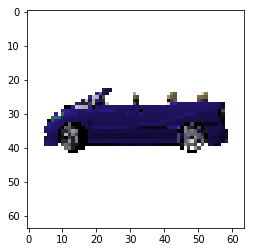

In [4]:
print(dataset.nbytes)
plt.imshow(dataset[711]/255)
plt.show()

In [5]:
 
total_models = dataset.shape[0] // total_azimuth_angles


train_models_len = int(total_models * train_split)
test_models_len = total_models - train_models_len

print(total_models,train_models_len,test_models_len)

3512 2809 703


In [6]:
dataset_train = dataset[:train_models_len*total_azimuth_angles]
dataset_test = dataset[train_models_len*total_azimuth_angles:]

print(dataset_test.shape)
print(dataset_train.shape)

(25308, 64, 64, 3)
(101124, 64, 64, 3)


In [7]:
del dataset
dataset_train.nbytes

1242611712

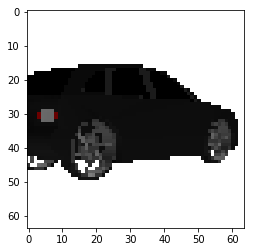

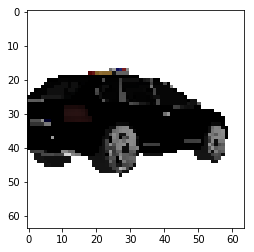

In [8]:
plt.imshow(dataset_train[1023]/255)
plt.show()
plt.imshow(dataset_test[1023]/255)
plt.show()

In [9]:
train_pairs = []
start_pose = [0]
for i in range(train_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                train_pairs.append((i,j,k))
                
test_pairs = []
start_pose = [0]
for i in range(test_models_len):
    for j in start_pose:
        for k in range(total_azimuth_angles):
            if j != k:
                test_pairs.append((i,j,k))


In [10]:
print(train_pairs[35])
print(test_pairs[35])
shuffle(train_pairs)
shuffle(test_pairs)
print(train_pairs[35])
print(test_pairs[35])

(1, 0, 1)
(1, 0, 1)
(2352, 0, 17)
(153, 0, 33)


(475, 0, 8)
(507, 0, 5)
98315


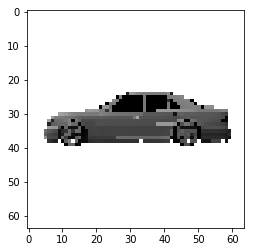

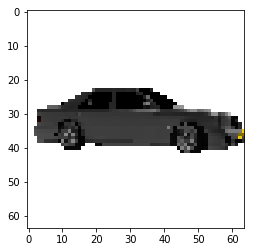

In [11]:
print(train_pairs[0])
print(test_pairs[0])

print(len(train_pairs))

i = dataset_train[(10*36) + 27]
j = dataset_train[(10*36) + 5]
plt.imshow(i/255)
plt.show()
plt.imshow(j/255)
plt.show()

In [12]:
def normalize(data):
    data = data * 2.0
    data = data / 255.0
    data = data - 1.0
    return data

def denormalize(data):
    data = data + 1.0
    data = data * 255.0
    data = data / 2.0
    return data

In [13]:
c = 0
for p in train_pairs:
    if p[0] == 12 and p[1] == 0:
        c += 1
print(c)

35


In [14]:
#pairs (index_no, input, output)
def get_batch_data(pairs, train=True):
    l = train_models_len if train else test_models_len
    d = dataset_train if train else dataset_test
    i, ip, op = 0, 1, 2
    batch, batch_labels, pose = [], [], []
    for p in pairs:
        ip_index = (p[i] * total_azimuth_angles) + p[1]
        batch.append(d[ip_index])
        
        op_index = (p[i] * total_azimuth_angles) + p[2]
        batch_labels.append(d[op_index])
        
        cur_pose =  np.zeros(36, dtype='uint8')
        cur_pose[(p[2] - p[1]) % total_azimuth_angles] = 1
        pose.append(np.broadcast_to(cur_pose,(pose_w, pose_h, pose_d)))
        
    batch = np.array(batch, dtype=np.float64)
    batch_labels = np.array(batch_labels, dtype=np.float64)
    pose = np.array(pose, dtype=np.float64)
    
    #normalize
    batch = normalize(batch)
    batch_labels =  normalize(batch_labels)
    
    return batch,batch_labels,pose

batch, batch_labels, pose_labels = get_batch_data(test_pairs[35*36:36*36], False)

(36, 64, 64, 3) (36, 64, 64, 3) (36, 4, 4, 36)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
<class 'numpy.float64'>
1.0 -1.0


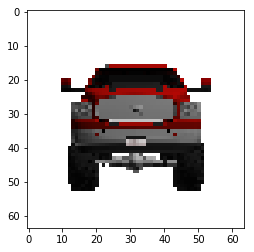

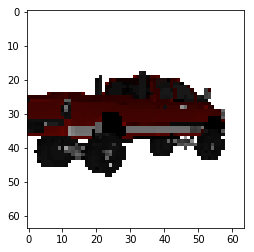

In [15]:
print(batch.shape, batch_labels.shape, pose_labels.shape)

t = 13
print(pose_labels[t][0][0])

print(type(batch_labels[t][0][0][0]))

print(np.max((batch[t])), np.min((batch[t])))

plt.imshow(denormalize(batch[t]) / 255)
plt.show()
plt.imshow(denormalize(batch_labels[t]) / 255)
plt.show()


In [16]:
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def conv2d(input, output, kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2d", act=lrelu):
    #act = tf.nn.leaky_relu
    with tf.variable_scope(scope_name):
        return layers.conv2d(inputs=input, num_outputs=output, kernel_size=[kernel_h, kernel_w], stride=k_stride, activation_fn=act,
         #biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02))
         biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer())
    
def deconv2d(input, kernel_size, stride, num_filter, scope_name='deconv2d', act=lrelu):
    with tf.variable_scope(scope_name): 
        stride_shape = [stride, stride]
        kernel_shape = [kernel_size, kernel_size]
        return layers.conv2d_transpose(inputs=input, num_outputs=num_filter, stride=stride_shape, kernel_size= kernel_shape,
            #padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.random_normal_initializer(0.0, 0.02),
            padding='SAME', biases_initializer=tf.zeros_initializer(), weights_initializer=tf.contrib.layers.xavier_initializer(),
            activation_fn=act
        )

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')


def batch_norm(inputs_, is_training):
    out = tf.contrib.layers.batch_norm(inputs_, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def l1_loss(inputs_, targets_):
    loss = tf.reduce_mean(abs(inputs_ - targets_))
    return loss

def ce_loss(labels, logits):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    return tf.reduce_mean(loss)

def local_moment_loss(pred, gt):
    with tf.name_scope('local_moment_loss'):

        ksz, kst = 4, 2
        local_patch = tf.ones((ksz, ksz, 1, 1))
        c = pred.get_shape()[-1]

        # Normalize by kernel size
        pr_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(pred, c, axis=3)], axis=3)
        pr_var = (pr_var - tf.square(pr_mean)/(ksz**2)) / (ksz ** 2)
        pr_mean = pr_mean / (ksz ** 2)

        gt_mean = tf.concat([tf.nn.conv2d(x, local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = tf.concat([tf.nn.conv2d(tf.square(x), local_patch, strides=[1, kst, kst, 1], padding='VALID') for x in tf.split(gt, c, axis=3)], axis=3)
        gt_var = (gt_var - tf.square(gt_mean)/(ksz**2)) / (ksz ** 2)
        gt_mean = gt_mean / (ksz ** 2)

        # scaling by local patch size
        local_mean_loss = tf.reduce_mean(tf.abs(pr_mean - gt_mean))
        local_var_loss = tf.reduce_mean(tf.abs(pr_var - gt_var))
    return local_mean_loss + local_var_loss
    

In [17]:
tf.reset_default_graph()

In [18]:
batch_size = 36
# tf Graph input (only pictures)
inputs_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")
targets_ = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="target")
pose_ = tf.placeholder(tf.float32, (batch_size, pose_w, pose_h, pose_d), name="pose")

disc_inputs = tf.placeholder(tf.float32, (batch_size, 64,64,3), name="input")

real_label = tf.placeholder(tf.float32, [batch_size, 1])
fake_label = tf.placeholder(tf.float32, [batch_size, 1])

In [19]:
ae_reuse= False
disc_reuse = False

#https://github.com/skaae/vaeblog

def auto_encoder(inputs_, pose_):
    global ae_reuse
    with tf.variable_scope('encoder', reuse=ae_reuse):
        ae_reuse = True
        _ = conv2d(inputs_, output=32 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv1",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=48 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv2",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=64 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv3",act=lrelu)
        _ = batch_norm(_, True)
        _ = conv2d(_, output=92 ,kernel_h=3, kernel_w=3, k_stride=2, scope_name="conv4",act=lrelu)# 4 * 4 * 128
        _ = tf.concat([pose_, _], 3)
       

        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=64, scope_name='deconv1',act=lrelu) # 8 * 8 * 64
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu) # 16 * 16 * 32
        gact = _
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu) # act = 32*32*16
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ , gact

'''
def generator(inputs_)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=32, scope_name='deconv2',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=16, scope_name='deconv3',act=lrelu)
        _ = batch_norm(_, True)
        _ = deconv2d(_, kernel_size=3, stride=2, num_filter=3, scope_name='deconv4',act=None)
        print("O1", _.get_shape())
        _ = tf.nn.tanh(_)
    return _ 
'''

# discriminator should give a fc layer
# No batch norm layer
def discriminator(inputs_):
    global disc_reuse 
    with tf.variable_scope('dis', reuse=disc_reuse):
        disc_reuse = True
        
        _ = conv2d(inputs_, output=16 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv1", act=lrelu) # 32 * 32 * 16
        print(_.get_shape())
        _ = conv2d(_, output=32 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv2", act=lrelu) # act 16*16*32
        dact = _
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_1')
        _ = conv2d(_, output=64 ,kernel_h=5, kernel_w=5, k_stride=2, scope_name="dis_conv3", act=lrelu)
        _ = tf.nn.dropout(_, keep_prob = 0.5, name='dis_drop_2')
        _ = tf.reshape(_, [-1, 8 * 8 * 64])        
        _ = fc(_, 1, 'dis_fc1')
        o1 = tf.nn.sigmoid(_)
        o2 = _
        o3 = dact
        return o1, o2, o3


In [20]:
global_step = tf.Variable(0,trainable=False)
lr = 5e-4

In [21]:
alpha = 0.000001 #0.2
beta = 1.0 #1.0


'''
generated_images = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise = auto_encoder(noise, pose_)

dreal, dreal_logits = discriminator(disc_inputs)
dfake, dfake_logits = discriminator(generated_images)
dnoise, dnoise_logits = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)


supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = gan_loss + supervised_loss
'''


generated_images, g_act_real = auto_encoder(inputs_, pose_)
noise = np.random.normal(0, 0.2, inputs_.get_shape()).astype(np.float32)
generated_noise, g_act_noise = auto_encoder(noise, pose_)

dreal, dreal_logits, dact_real = discriminator(disc_inputs)
dfake, dfake_logits, dact_fake = discriminator(generated_images)
dnoise, dnoise_logits, dact_noise = discriminator(generated_noise)


dreal_labels = tf.zeros_like(dreal, dtype=tf.float32)
dfake_labels = 0.98 * tf.ones_like(dfake, dtype=tf.float32)

dreal_loss = ce_loss(dreal_labels, dreal_logits) #+ 0.2 * ce_loss(dfake_labels, dnoise_logits)
dfake_loss = ce_loss(dfake_labels, dfake_logits)# + 
dis_loss_op = dreal_loss + dfake_loss 


#g_act_real = tf.contrib.layers.flatten(g_act_real)
#dact_real = tf.contrib.layers.flatten(dact_real)
#g_act_noise = tf.contrib.layers.flatten(g_act_noise)
#dact_noise = tf.contrib.layers.flatten(dact_noise)
#gan_loss = alpha * ce_loss(tf.zeros_like(dfake), dfake_logits)
#gan_loss = alpha * ce_loss(tf.ones_like(dfake), dfake_logits)
gan_loss = tf.sqrt(tf.reduce_sum(tf.pow((g_act_real - dact_real), 2))) +  tf.sqrt(tf.reduce_sum(tf.pow(g_act_noise - dact_noise, 2)))
#gan_loss = alpha * gan_loss
supervised_loss = beta * l1_loss(generated_images, targets_)
#supervised_loss = beta * local_moment_loss(generated_images, targets_)
gen_loss_op = alpha * gan_loss + supervised_loss

# Build Loss
#gen_loss_op = -tf.reduce_mean(tf.log(dis_fake_samples_op))
#dis_loss_op = -tf.reduce_mean(tf.log(dis_real_samples_op) + tf.log(1. - dis_fake_samples_op))

# Build Optimizers
#optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
#optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)




O1 (36, 64, 64, 3)
O1 (36, 64, 64, 3)
(36, 32, 32, 16)
(36, 32, 32, 16)
(36, 32, 32, 16)


In [22]:
disriminator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
generator_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
#print (generator_vars)
#dis_optimizer = tf.train.RMSPropOptimizer(lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.RMSPropOptimizer(lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)


#dis_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)
#gen_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
#gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)
dlr = 1e-6#1e-4
glr = 1e-3#5e-4

dis_optimizer = tf.train.AdamOptimizer(dlr)
dis_train_op = dis_optimizer.minimize(dis_loss_op, var_list=disriminator_vars)

gen_optimizer = tf.train.AdamOptimizer(glr)
gen_train_op = gen_optimizer.minimize(gen_loss_op, var_list=generator_vars)

'''
dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
gvs = dis_optimizer.compute_gradients(dis_loss_op, var_list=generator_vars)
gcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(gcapped_gvs)


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
gvs = gen_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars)
dcapped_gvs = [(tf.clip_by_value(grad, -10.0, 10.0), var) for grad, var in gvs]
dis_train_op = dis_optimizer.apply_gradients(dcapped_gvs)
'''

'''
dis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)
dgradients, dvariables = zip(*dis_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars))
dgradients, _ = tf.clip_by_global_norm(dgradients, 5.0)
dis_train_op = dis_optimizer.apply_gradients(zip(dgradients, dvariables))


gen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)
ggradients, gvariables = zip(*gen_optimizer.compute_gradients(gen_loss_op, var_list=generator_vars))
ggradients, _ = tf.clip_by_global_norm(ggradients, 5.0)
gen_train_op = gen_optimizer.apply_gradients(zip(ggradients, gvariables))
'''






'\ndis_optimizer = tf.train.AdamOptimizer(learning_rate=dlr)\ndgradients, dvariables = zip(*dis_optimizer.compute_gradients(dis_loss_op, var_list=disriminator_vars))\ndgradients, _ = tf.clip_by_global_norm(dgradients, 5.0)\ndis_train_op = dis_optimizer.apply_gradients(zip(dgradients, dvariables))\n\n\ngen_optimizer = tf.train.AdamOptimizer(learning_rate=glr)\nggradients, gvariables = zip(*gen_optimizer.compute_gradients(gen_loss_op, var_list=generator_vars))\nggradients, _ = tf.clip_by_global_norm(ggradients, 5.0)\ngen_train_op = gen_optimizer.apply_gradients(zip(ggradients, gvariables))\n'

Step 10: dloss = 7.8285, gloss = 0.8235, real_loss = 7.0702, fake_loss = 0.7583, gan_loss = 19501.4277 l1_loss = 0.8040
Step 20: dloss = 20.1857, gloss = 0.6991, real_loss = 19.4297, fake_loss = 0.7560, gan_loss = 19764.7539 l1_loss = 0.6793
Step 30: dloss = 13.5256, gloss = 0.6018, real_loss = 12.7536, fake_loss = 0.7720, gan_loss = 19959.7344 l1_loss = 0.5819
Step 40: dloss = 10.2330, gloss = 0.5452, real_loss = 9.4580, fake_loss = 0.7750, gan_loss = 19040.3164 l1_loss = 0.5261
Step 50: dloss = 11.0959, gloss = 0.4744, real_loss = 10.2991, fake_loss = 0.7968, gan_loss = 19319.1270 l1_loss = 0.4551
Step 60: dloss = 3.6884, gloss = 0.4198, real_loss = 2.8800, fake_loss = 0.8085, gan_loss = 19956.4043 l1_loss = 0.3999
Step 70: dloss = 9.3630, gloss = 0.3805, real_loss = 8.5797, fake_loss = 0.7833, gan_loss = 17977.5898 l1_loss = 0.3625
Step 80: dloss = 13.7071, gloss = 0.3554, real_loss = 12.9408, fake_loss = 0.7663, gan_loss = 18728.2910 l1_loss = 0.3367
Step 90: dloss = 10.2068, gloss

Step 690: dloss = 6.3058, gloss = 0.1556, real_loss = 5.5139, fake_loss = 0.7919, gan_loss = 19468.6504 l1_loss = 0.1361
Step 700: dloss = 10.9056, gloss = 0.1544, real_loss = 10.1121, fake_loss = 0.7935, gan_loss = 19457.9473 l1_loss = 0.1350
Step 710: dloss = 4.5738, gloss = 0.1653, real_loss = 3.7987, fake_loss = 0.7751, gan_loss = 18714.6250 l1_loss = 0.1466
Step 720: dloss = 5.3548, gloss = 0.1544, real_loss = 4.5786, fake_loss = 0.7762, gan_loss = 19486.3516 l1_loss = 0.1350
Step 730: dloss = 6.5139, gloss = 0.1811, real_loss = 5.7386, fake_loss = 0.7753, gan_loss = 19101.9434 l1_loss = 0.1620
Step 740: dloss = 5.1273, gloss = 0.1593, real_loss = 4.3480, fake_loss = 0.7792, gan_loss = 18978.2461 l1_loss = 0.1403
Step 750: dloss = 5.3106, gloss = 0.1558, real_loss = 4.5252, fake_loss = 0.7854, gan_loss = 19131.7090 l1_loss = 0.1367
Step 760: dloss = 5.6722, gloss = 0.1429, real_loss = 4.8871, fake_loss = 0.7850, gan_loss = 18896.3281 l1_loss = 0.1240
Step 770: dloss = 8.9258, glos

Step 1370: dloss = 3.2404, gloss = 0.1482, real_loss = 2.4198, fake_loss = 0.8206, gan_loss = 19616.0820 l1_loss = 0.1286
Step 1380: dloss = 3.8100, gloss = 0.1390, real_loss = 3.0241, fake_loss = 0.7859, gan_loss = 19405.0059 l1_loss = 0.1196
Step 1390: dloss = 3.9709, gloss = 0.1470, real_loss = 3.1463, fake_loss = 0.8245, gan_loss = 19081.2031 l1_loss = 0.1279
Step 1400: dloss = 4.5183, gloss = 0.1550, real_loss = 3.7391, fake_loss = 0.7793, gan_loss = 18928.4160 l1_loss = 0.1361
Step 1410: dloss = 4.4182, gloss = 0.1446, real_loss = 3.6322, fake_loss = 0.7860, gan_loss = 19735.5898 l1_loss = 0.1248
Step 1420: dloss = 5.4769, gloss = 0.1446, real_loss = 4.6608, fake_loss = 0.8161, gan_loss = 19201.2227 l1_loss = 0.1254
Step 1430: dloss = 4.7511, gloss = 0.1414, real_loss = 3.9532, fake_loss = 0.7980, gan_loss = 19354.6523 l1_loss = 0.1221
Step 1440: dloss = 5.4595, gloss = 0.1592, real_loss = 4.6717, fake_loss = 0.7878, gan_loss = 19228.2305 l1_loss = 0.1400
Step 1450: dloss = 5.628

Step 2050: dloss = 1.8430, gloss = 0.1309, real_loss = 0.9966, fake_loss = 0.8465, gan_loss = 19039.9824 l1_loss = 0.1118
Step 2060: dloss = 3.3538, gloss = 0.1322, real_loss = 2.4769, fake_loss = 0.8770, gan_loss = 17686.5488 l1_loss = 0.1145
Step 2070: dloss = 3.7124, gloss = 0.1252, real_loss = 2.8863, fake_loss = 0.8261, gan_loss = 18577.0312 l1_loss = 0.1066
Step 2080: dloss = 0.9303, gloss = 0.1392, real_loss = 0.1285, fake_loss = 0.8018, gan_loss = 18247.9941 l1_loss = 0.1209
Step 2090: dloss = 2.2864, gloss = 0.1231, real_loss = 1.4682, fake_loss = 0.8182, gan_loss = 18781.0977 l1_loss = 0.1044
Step 2100: dloss = 2.8283, gloss = 0.1339, real_loss = 1.9991, fake_loss = 0.8293, gan_loss = 18125.5781 l1_loss = 0.1157
Step 2110: dloss = 3.1702, gloss = 0.1362, real_loss = 2.3542, fake_loss = 0.8160, gan_loss = 19098.3750 l1_loss = 0.1171
Step 2120: dloss = 3.4726, gloss = 0.1279, real_loss = 2.6463, fake_loss = 0.8262, gan_loss = 19319.4004 l1_loss = 0.1086
Step 2130: dloss = 2.128

Step 2730: dloss = 0.8486, gloss = 0.1318, real_loss = 0.0002, fake_loss = 0.8484, gan_loss = 19337.3164 l1_loss = 0.1125
Epoch 0: dis loss = 0.8486, gen loss = 0.1318, real_label_loss = 0.0002, fake_label_loss = 0.8484


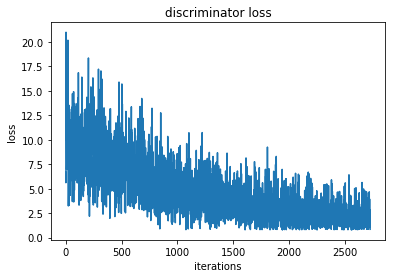

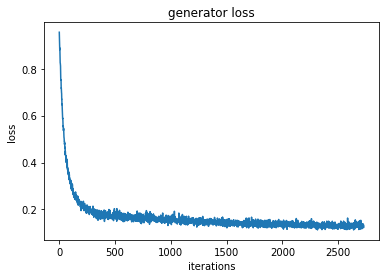

Step 2740: dloss = 2.1892, gloss = 0.1254, real_loss = 1.3453, fake_loss = 0.8439, gan_loss = 18781.4609 l1_loss = 0.1066
Step 2750: dloss = 1.5697, gloss = 0.1224, real_loss = 0.6813, fake_loss = 0.8884, gan_loss = 19037.6562 l1_loss = 0.1034
Step 2760: dloss = 1.2539, gloss = 0.1252, real_loss = 0.4415, fake_loss = 0.8124, gan_loss = 19275.1641 l1_loss = 0.1059
Step 2770: dloss = 1.9263, gloss = 0.1349, real_loss = 1.1055, fake_loss = 0.8208, gan_loss = 18941.2578 l1_loss = 0.1159
Step 2780: dloss = 2.8966, gloss = 0.1368, real_loss = 2.0804, fake_loss = 0.8162, gan_loss = 19067.6543 l1_loss = 0.1177
Step 2790: dloss = 1.5604, gloss = 0.1232, real_loss = 0.7525, fake_loss = 0.8079, gan_loss = 18842.1133 l1_loss = 0.1043
Step 2800: dloss = 2.9463, gloss = 0.1362, real_loss = 2.0980, fake_loss = 0.8484, gan_loss = 18682.0605 l1_loss = 0.1175
Step 2810: dloss = 2.9084, gloss = 0.1256, real_loss = 2.0795, fake_loss = 0.8290, gan_loss = 18927.2520 l1_loss = 0.1067
Step 2820: dloss = 3.998

Step 3420: dloss = 1.2118, gloss = 0.1195, real_loss = 0.3796, fake_loss = 0.8322, gan_loss = 18395.6230 l1_loss = 0.1011
Step 3430: dloss = 1.1122, gloss = 0.1192, real_loss = 0.2720, fake_loss = 0.8402, gan_loss = 18498.8457 l1_loss = 0.1007
Step 3440: dloss = 1.2782, gloss = 0.1317, real_loss = 0.4393, fake_loss = 0.8389, gan_loss = 19164.1133 l1_loss = 0.1125
Step 3450: dloss = 0.8492, gloss = 0.1211, real_loss = 0.0010, fake_loss = 0.8483, gan_loss = 18263.7480 l1_loss = 0.1029
Step 3460: dloss = 1.0768, gloss = 0.1372, real_loss = 0.2388, fake_loss = 0.8380, gan_loss = 18700.8027 l1_loss = 0.1185
Step 3470: dloss = 1.4247, gloss = 0.1231, real_loss = 0.6158, fake_loss = 0.8089, gan_loss = 19115.5195 l1_loss = 0.1040
Step 3480: dloss = 1.3772, gloss = 0.1236, real_loss = 0.5271, fake_loss = 0.8501, gan_loss = 18868.4570 l1_loss = 0.1048
Step 3490: dloss = 1.6749, gloss = 0.1127, real_loss = 0.8401, fake_loss = 0.8348, gan_loss = 18857.9609 l1_loss = 0.0939
Step 3500: dloss = 2.232

Step 4100: dloss = 1.6945, gloss = 0.1213, real_loss = 0.8265, fake_loss = 0.8679, gan_loss = 17883.5547 l1_loss = 0.1034
Step 4110: dloss = 2.2458, gloss = 0.1181, real_loss = 1.3934, fake_loss = 0.8524, gan_loss = 19057.6445 l1_loss = 0.0990
Step 4120: dloss = 0.9082, gloss = 0.1219, real_loss = 0.0404, fake_loss = 0.8678, gan_loss = 19347.2871 l1_loss = 0.1026
Step 4130: dloss = 1.2827, gloss = 0.1300, real_loss = 0.4431, fake_loss = 0.8396, gan_loss = 18994.6465 l1_loss = 0.1111
Step 4140: dloss = 0.8689, gloss = 0.1240, real_loss = 0.0000, fake_loss = 0.8689, gan_loss = 18701.7305 l1_loss = 0.1053
Step 4150: dloss = 0.8704, gloss = 0.1225, real_loss = 0.0054, fake_loss = 0.8650, gan_loss = 19344.4219 l1_loss = 0.1031
Step 4160: dloss = 1.2774, gloss = 0.1214, real_loss = 0.4121, fake_loss = 0.8653, gan_loss = 19006.7773 l1_loss = 0.1024
Step 4170: dloss = 1.3144, gloss = 0.1355, real_loss = 0.4539, fake_loss = 0.8604, gan_loss = 18692.6582 l1_loss = 0.1168
Step 4180: dloss = 1.946

Step 4780: dloss = 1.9679, gloss = 0.1184, real_loss = 1.0958, fake_loss = 0.8721, gan_loss = 17853.8262 l1_loss = 0.1005
Step 4790: dloss = 0.8525, gloss = 0.1239, real_loss = 0.0000, fake_loss = 0.8525, gan_loss = 18745.7324 l1_loss = 0.1051
Step 4800: dloss = 1.0314, gloss = 0.1149, real_loss = 0.1721, fake_loss = 0.8594, gan_loss = 18421.8711 l1_loss = 0.0965
Step 4810: dloss = 0.8475, gloss = 0.1289, real_loss = 0.0089, fake_loss = 0.8386, gan_loss = 19078.4355 l1_loss = 0.1099
Step 4820: dloss = 1.0643, gloss = 0.1133, real_loss = 0.2065, fake_loss = 0.8579, gan_loss = 19677.0234 l1_loss = 0.0937
Step 4830: dloss = 1.9520, gloss = 0.1228, real_loss = 1.0843, fake_loss = 0.8678, gan_loss = 19565.7773 l1_loss = 0.1032
Step 4840: dloss = 2.4442, gloss = 0.1225, real_loss = 1.5927, fake_loss = 0.8515, gan_loss = 19192.9375 l1_loss = 0.1033
Step 4850: dloss = 0.8661, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8661, gan_loss = 18275.3809 l1_loss = 0.0933
Step 4860: dloss = 1.151

Step 5460: dloss = 0.8337, gloss = 0.1228, real_loss = 0.0000, fake_loss = 0.8337, gan_loss = 18944.0586 l1_loss = 0.1039
Epoch 1: dis loss = 0.8337, gen loss = 0.1228, real_label_loss = 0.0000, fake_label_loss = 0.8337


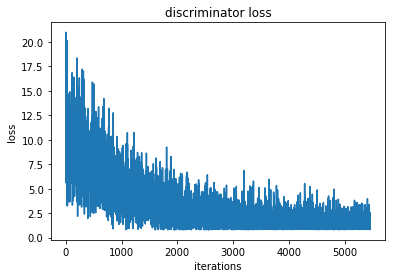

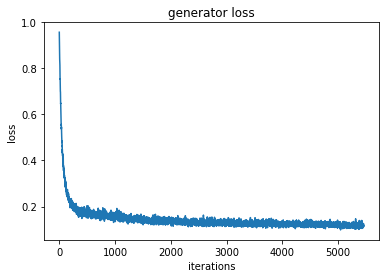

Step 5470: dloss = 0.9026, gloss = 0.1135, real_loss = 0.0346, fake_loss = 0.8680, gan_loss = 18019.3594 l1_loss = 0.0954
Step 5480: dloss = 2.4488, gloss = 0.1132, real_loss = 1.5598, fake_loss = 0.8891, gan_loss = 18745.8418 l1_loss = 0.0944
Step 5490: dloss = 1.4182, gloss = 0.1142, real_loss = 0.5817, fake_loss = 0.8365, gan_loss = 18383.2520 l1_loss = 0.0958
Step 5500: dloss = 0.9566, gloss = 0.1246, real_loss = 0.1203, fake_loss = 0.8363, gan_loss = 18698.5117 l1_loss = 0.1059
Step 5510: dloss = 1.2941, gloss = 0.1247, real_loss = 0.4237, fake_loss = 0.8704, gan_loss = 18274.9688 l1_loss = 0.1064
Step 5520: dloss = 3.6715, gloss = 0.1109, real_loss = 2.8114, fake_loss = 0.8601, gan_loss = 18852.0840 l1_loss = 0.0920
Step 5530: dloss = 1.4208, gloss = 0.1269, real_loss = 0.5638, fake_loss = 0.8570, gan_loss = 19267.5254 l1_loss = 0.1076
Step 5540: dloss = 0.9521, gloss = 0.1141, real_loss = 0.1106, fake_loss = 0.8415, gan_loss = 19474.8027 l1_loss = 0.0946
Step 5550: dloss = 1.343

Step 6150: dloss = 0.9378, gloss = 0.1123, real_loss = 0.0998, fake_loss = 0.8380, gan_loss = 18441.2539 l1_loss = 0.0939
Step 6160: dloss = 0.8685, gloss = 0.1112, real_loss = 0.0003, fake_loss = 0.8682, gan_loss = 19119.6797 l1_loss = 0.0921
Step 6170: dloss = 1.7207, gloss = 0.1218, real_loss = 0.8602, fake_loss = 0.8605, gan_loss = 19277.1465 l1_loss = 0.1025
Step 6180: dloss = 1.2981, gloss = 0.1106, real_loss = 0.4180, fake_loss = 0.8801, gan_loss = 18576.7715 l1_loss = 0.0920
Step 6190: dloss = 1.3508, gloss = 0.1262, real_loss = 0.4943, fake_loss = 0.8565, gan_loss = 18791.0586 l1_loss = 0.1074
Step 6200: dloss = 1.1913, gloss = 0.1147, real_loss = 0.3471, fake_loss = 0.8442, gan_loss = 18749.2754 l1_loss = 0.0960
Step 6210: dloss = 1.6497, gloss = 0.1121, real_loss = 0.7667, fake_loss = 0.8830, gan_loss = 19009.6328 l1_loss = 0.0931
Step 6220: dloss = 1.9562, gloss = 0.1020, real_loss = 1.1001, fake_loss = 0.8560, gan_loss = 19096.3457 l1_loss = 0.0829
Step 6230: dloss = 0.861

Step 6830: dloss = 0.8857, gloss = 0.1128, real_loss = 0.0000, fake_loss = 0.8857, gan_loss = 19410.7480 l1_loss = 0.0934
Step 6840: dloss = 3.0270, gloss = 0.1083, real_loss = 2.1631, fake_loss = 0.8639, gan_loss = 17359.8750 l1_loss = 0.0910
Step 6850: dloss = 0.8392, gloss = 0.1120, real_loss = 0.0000, fake_loss = 0.8392, gan_loss = 19059.3359 l1_loss = 0.0929
Step 6860: dloss = 0.8571, gloss = 0.1214, real_loss = 0.0000, fake_loss = 0.8571, gan_loss = 18667.1348 l1_loss = 0.1028
Step 6870: dloss = 1.1449, gloss = 0.1174, real_loss = 0.2885, fake_loss = 0.8564, gan_loss = 19086.6133 l1_loss = 0.0983
Step 6880: dloss = 0.8594, gloss = 0.1141, real_loss = 0.0000, fake_loss = 0.8594, gan_loss = 19085.4902 l1_loss = 0.0950
Step 6890: dloss = 0.9934, gloss = 0.1094, real_loss = 0.0988, fake_loss = 0.8946, gan_loss = 18620.6973 l1_loss = 0.0908
Step 6900: dloss = 1.0703, gloss = 0.1248, real_loss = 0.2391, fake_loss = 0.8312, gan_loss = 18781.5000 l1_loss = 0.1060
Step 6910: dloss = 0.870

Step 7510: dloss = 0.8771, gloss = 0.1097, real_loss = 0.0000, fake_loss = 0.8771, gan_loss = 19620.7930 l1_loss = 0.0901
Step 7520: dloss = 0.8640, gloss = 0.1154, real_loss = 0.0000, fake_loss = 0.8640, gan_loss = 18813.1074 l1_loss = 0.0966
Step 7530: dloss = 1.1807, gloss = 0.1066, real_loss = 0.3143, fake_loss = 0.8664, gan_loss = 18448.4375 l1_loss = 0.0881
Step 7540: dloss = 0.8584, gloss = 0.1185, real_loss = 0.0000, fake_loss = 0.8584, gan_loss = 17840.0059 l1_loss = 0.1007
Step 7550: dloss = 1.0102, gloss = 0.1056, real_loss = 0.1768, fake_loss = 0.8333, gan_loss = 18981.6289 l1_loss = 0.0866
Step 7560: dloss = 0.8493, gloss = 0.1148, real_loss = 0.0035, fake_loss = 0.8458, gan_loss = 18693.4961 l1_loss = 0.0961
Step 7570: dloss = 1.4093, gloss = 0.1146, real_loss = 0.5353, fake_loss = 0.8740, gan_loss = 18892.9316 l1_loss = 0.0957
Step 7580: dloss = 0.8876, gloss = 0.1058, real_loss = 0.0000, fake_loss = 0.8876, gan_loss = 17842.3965 l1_loss = 0.0880
Step 7590: dloss = 2.538

Step 8190: dloss = 1.3235, gloss = 0.1161, real_loss = 0.4467, fake_loss = 0.8768, gan_loss = 18460.0664 l1_loss = 0.0977
Epoch 2: dis loss = 1.3235, gen loss = 0.1161, real_label_loss = 0.4467, fake_label_loss = 0.8768


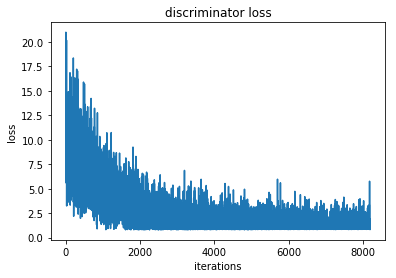

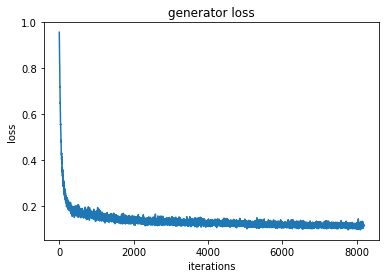

Step 8200: dloss = 1.2465, gloss = 0.1105, real_loss = 0.4270, fake_loss = 0.8195, gan_loss = 18830.7227 l1_loss = 0.0917
Step 8210: dloss = 1.0719, gloss = 0.1065, real_loss = 0.1900, fake_loss = 0.8819, gan_loss = 17743.9375 l1_loss = 0.0887
Step 8220: dloss = 0.8774, gloss = 0.1094, real_loss = 0.0001, fake_loss = 0.8772, gan_loss = 18787.1367 l1_loss = 0.0906
Step 8230: dloss = 0.8390, gloss = 0.1187, real_loss = 0.0000, fake_loss = 0.8390, gan_loss = 18986.5840 l1_loss = 0.0997
Step 8240: dloss = 1.1942, gloss = 0.1178, real_loss = 0.3358, fake_loss = 0.8583, gan_loss = 18901.8027 l1_loss = 0.0989
Step 8250: dloss = 0.8610, gloss = 0.1045, real_loss = 0.0075, fake_loss = 0.8535, gan_loss = 19063.1094 l1_loss = 0.0854
Step 8260: dloss = 0.8869, gloss = 0.1189, real_loss = 0.0000, fake_loss = 0.8869, gan_loss = 17685.2832 l1_loss = 0.1013
Step 8270: dloss = 1.2387, gloss = 0.1056, real_loss = 0.3614, fake_loss = 0.8774, gan_loss = 18778.4668 l1_loss = 0.0869
Step 8280: dloss = 1.282

Step 8880: dloss = 1.9415, gloss = 0.1079, real_loss = 1.0713, fake_loss = 0.8702, gan_loss = 18711.7969 l1_loss = 0.0892
Step 8890: dloss = 0.9456, gloss = 0.1058, real_loss = 0.1195, fake_loss = 0.8261, gan_loss = 19312.6562 l1_loss = 0.0865
Step 8900: dloss = 1.3293, gloss = 0.1145, real_loss = 0.4663, fake_loss = 0.8630, gan_loss = 18876.5664 l1_loss = 0.0956
Step 8910: dloss = 3.1328, gloss = 0.1054, real_loss = 2.2324, fake_loss = 0.9004, gan_loss = 18816.8965 l1_loss = 0.0866
Step 8920: dloss = 0.9787, gloss = 0.1207, real_loss = 0.1176, fake_loss = 0.8612, gan_loss = 18662.4668 l1_loss = 0.1021
Step 8930: dloss = 0.8776, gloss = 0.1104, real_loss = 0.0001, fake_loss = 0.8775, gan_loss = 18552.3613 l1_loss = 0.0918
Step 8940: dloss = 0.8920, gloss = 0.1067, real_loss = 0.0111, fake_loss = 0.8809, gan_loss = 18171.5273 l1_loss = 0.0885
Step 8950: dloss = 0.8884, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8884, gan_loss = 18610.9922 l1_loss = 0.0790
Step 8960: dloss = 0.862

Step 9560: dloss = 0.8445, gloss = 0.1076, real_loss = 0.0038, fake_loss = 0.8408, gan_loss = 18623.9785 l1_loss = 0.0890
Step 9570: dloss = 1.0411, gloss = 0.1065, real_loss = 0.1725, fake_loss = 0.8686, gan_loss = 18929.5039 l1_loss = 0.0876
Step 9580: dloss = 1.3111, gloss = 0.1091, real_loss = 0.4535, fake_loss = 0.8576, gan_loss = 18808.0605 l1_loss = 0.0903
Step 9590: dloss = 0.8759, gloss = 0.1130, real_loss = 0.0000, fake_loss = 0.8759, gan_loss = 18978.2363 l1_loss = 0.0940
Step 9600: dloss = 0.8815, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8815, gan_loss = 18614.2617 l1_loss = 0.0912
Step 9610: dloss = 0.8596, gloss = 0.1111, real_loss = 0.0050, fake_loss = 0.8546, gan_loss = 18481.3477 l1_loss = 0.0926
Step 9620: dloss = 0.8619, gloss = 0.1035, real_loss = 0.0000, fake_loss = 0.8619, gan_loss = 17482.9746 l1_loss = 0.0860
Step 9630: dloss = 0.8662, gloss = 0.1157, real_loss = 0.0000, fake_loss = 0.8662, gan_loss = 18501.9551 l1_loss = 0.0972
Step 9640: dloss = 0.880

Step 10230: dloss = 1.5821, gloss = 0.1134, real_loss = 0.6768, fake_loss = 0.9053, gan_loss = 18797.0684 l1_loss = 0.0946
Step 10240: dloss = 0.8991, gloss = 0.1061, real_loss = 0.0002, fake_loss = 0.8989, gan_loss = 18411.6758 l1_loss = 0.0877
Step 10250: dloss = 1.2368, gloss = 0.1121, real_loss = 0.3413, fake_loss = 0.8955, gan_loss = 18989.2578 l1_loss = 0.0931
Step 10260: dloss = 1.2111, gloss = 0.1038, real_loss = 0.3517, fake_loss = 0.8594, gan_loss = 18841.1328 l1_loss = 0.0849
Step 10270: dloss = 0.8624, gloss = 0.1159, real_loss = 0.0000, fake_loss = 0.8624, gan_loss = 18169.4004 l1_loss = 0.0978
Step 10280: dloss = 1.1493, gloss = 0.1040, real_loss = 0.2365, fake_loss = 0.9129, gan_loss = 18632.4980 l1_loss = 0.0854
Step 10290: dloss = 1.3882, gloss = 0.1099, real_loss = 0.5310, fake_loss = 0.8573, gan_loss = 18573.1094 l1_loss = 0.0914
Step 10300: dloss = 1.5516, gloss = 0.1121, real_loss = 0.6820, fake_loss = 0.8696, gan_loss = 18792.6191 l1_loss = 0.0933
Step 10310: dlos

Step 10900: dloss = 1.1228, gloss = 0.1180, real_loss = 0.2591, fake_loss = 0.8637, gan_loss = 18955.3223 l1_loss = 0.0990
Step 10910: dloss = 0.9823, gloss = 0.1108, real_loss = 0.0806, fake_loss = 0.9017, gan_loss = 18444.4414 l1_loss = 0.0924
Step 10920: dloss = 0.8688, gloss = 0.1115, real_loss = 0.0000, fake_loss = 0.8687, gan_loss = 17662.4297 l1_loss = 0.0939
Epoch 3: dis loss = 0.8688, gen loss = 0.1115, real_label_loss = 0.0000, fake_label_loss = 0.8687


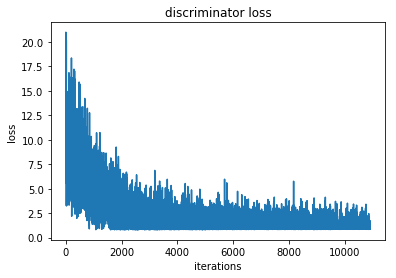

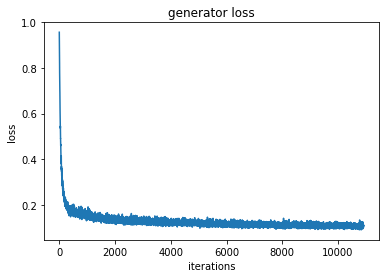

Step 10930: dloss = 1.9317, gloss = 0.1094, real_loss = 1.0720, fake_loss = 0.8597, gan_loss = 18692.1211 l1_loss = 0.0907
Step 10940: dloss = 0.8643, gloss = 0.1072, real_loss = 0.0038, fake_loss = 0.8604, gan_loss = 18829.2383 l1_loss = 0.0884
Step 10950: dloss = 0.8567, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8567, gan_loss = 17477.9473 l1_loss = 0.0870
Step 10960: dloss = 1.4442, gloss = 0.1149, real_loss = 0.5688, fake_loss = 0.8754, gan_loss = 19074.6914 l1_loss = 0.0958
Step 10970: dloss = 0.8775, gloss = 0.1150, real_loss = 0.0000, fake_loss = 0.8775, gan_loss = 19401.9004 l1_loss = 0.0956
Step 10980: dloss = 0.8724, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8724, gan_loss = 18418.6445 l1_loss = 0.0814
Step 10990: dloss = 0.8580, gloss = 0.1168, real_loss = 0.0000, fake_loss = 0.8580, gan_loss = 18751.8008 l1_loss = 0.0981
Step 11000: dloss = 1.2724, gloss = 0.1000, real_loss = 0.3875, fake_loss = 0.8849, gan_loss = 18124.5332 l1_loss = 0.0819
Step 11010: dlos

Step 11600: dloss = 1.9460, gloss = 0.1064, real_loss = 1.0819, fake_loss = 0.8641, gan_loss = 19217.0605 l1_loss = 0.0872
Step 11610: dloss = 0.8670, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8670, gan_loss = 19048.6523 l1_loss = 0.0858
Step 11620: dloss = 0.8681, gloss = 0.1029, real_loss = 0.0009, fake_loss = 0.8672, gan_loss = 18410.8184 l1_loss = 0.0844
Step 11630: dloss = 0.8941, gloss = 0.1116, real_loss = 0.0000, fake_loss = 0.8941, gan_loss = 19056.6855 l1_loss = 0.0925
Step 11640: dloss = 1.1530, gloss = 0.1021, real_loss = 0.2820, fake_loss = 0.8710, gan_loss = 18859.4609 l1_loss = 0.0832
Step 11650: dloss = 1.6715, gloss = 0.1165, real_loss = 0.8039, fake_loss = 0.8675, gan_loss = 18049.5762 l1_loss = 0.0984
Step 11660: dloss = 1.0989, gloss = 0.1087, real_loss = 0.1934, fake_loss = 0.9055, gan_loss = 19154.5293 l1_loss = 0.0896
Step 11670: dloss = 0.9171, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.9171, gan_loss = 18586.0371 l1_loss = 0.0836
Step 11680: dlos

Step 12270: dloss = 0.9192, gloss = 0.1004, real_loss = 0.0211, fake_loss = 0.8981, gan_loss = 18647.9531 l1_loss = 0.0818
Step 12280: dloss = 0.8667, gloss = 0.1028, real_loss = 0.0002, fake_loss = 0.8664, gan_loss = 17960.7070 l1_loss = 0.0848
Step 12290: dloss = 0.9253, gloss = 0.1071, real_loss = 0.0199, fake_loss = 0.9054, gan_loss = 19128.5723 l1_loss = 0.0880
Step 12300: dloss = 1.2465, gloss = 0.1037, real_loss = 0.3184, fake_loss = 0.9281, gan_loss = 18572.8574 l1_loss = 0.0851
Step 12310: dloss = 0.9049, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.9049, gan_loss = 19120.3047 l1_loss = 0.0875
Step 12320: dloss = 0.8850, gloss = 0.1086, real_loss = 0.0000, fake_loss = 0.8850, gan_loss = 18658.1055 l1_loss = 0.0900
Step 12330: dloss = 0.8723, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.8723, gan_loss = 18775.9941 l1_loss = 0.0871
Step 12340: dloss = 0.8826, gloss = 0.1063, real_loss = 0.0000, fake_loss = 0.8826, gan_loss = 19357.0312 l1_loss = 0.0870
Step 12350: dlos

Step 12940: dloss = 0.9175, gloss = 0.1090, real_loss = 0.0000, fake_loss = 0.9175, gan_loss = 19233.5723 l1_loss = 0.0898
Step 12950: dloss = 1.3188, gloss = 0.1107, real_loss = 0.4220, fake_loss = 0.8967, gan_loss = 18573.7578 l1_loss = 0.0921
Step 12960: dloss = 0.8646, gloss = 0.1129, real_loss = 0.0000, fake_loss = 0.8646, gan_loss = 18097.6582 l1_loss = 0.0948
Step 12970: dloss = 1.6689, gloss = 0.1028, real_loss = 0.7731, fake_loss = 0.8958, gan_loss = 18470.5078 l1_loss = 0.0844
Step 12980: dloss = 0.8827, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8827, gan_loss = 18777.5176 l1_loss = 0.0905
Step 12990: dloss = 1.0168, gloss = 0.1007, real_loss = 0.1325, fake_loss = 0.8843, gan_loss = 18452.9141 l1_loss = 0.0822
Step 13000: dloss = 1.4196, gloss = 0.1127, real_loss = 0.5643, fake_loss = 0.8554, gan_loss = 18625.1719 l1_loss = 0.0940
Step 13010: dloss = 0.8369, gloss = 0.0998, real_loss = 0.0000, fake_loss = 0.8368, gan_loss = 18681.7344 l1_loss = 0.0811
Step 13020: dlos

Step 13610: dloss = 1.0841, gloss = 0.1184, real_loss = 0.2036, fake_loss = 0.8805, gan_loss = 18030.7031 l1_loss = 0.1004
Step 13620: dloss = 0.8999, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8999, gan_loss = 19015.3359 l1_loss = 0.0801
Step 13630: dloss = 0.8792, gloss = 0.1148, real_loss = 0.0000, fake_loss = 0.8792, gan_loss = 19254.9277 l1_loss = 0.0955
Step 13640: dloss = 0.9796, gloss = 0.1077, real_loss = 0.1098, fake_loss = 0.8698, gan_loss = 18445.7793 l1_loss = 0.0892
Step 13650: dloss = 0.8973, gloss = 0.1085, real_loss = 0.0000, fake_loss = 0.8973, gan_loss = 18215.4922 l1_loss = 0.0903
Epoch 4: dis loss = 0.8973, gen loss = 0.1085, real_label_loss = 0.0000, fake_label_loss = 0.8973


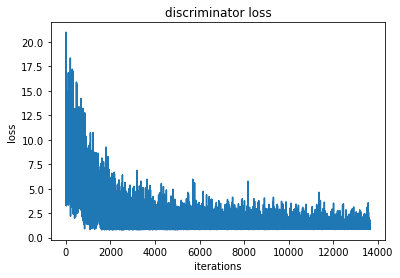

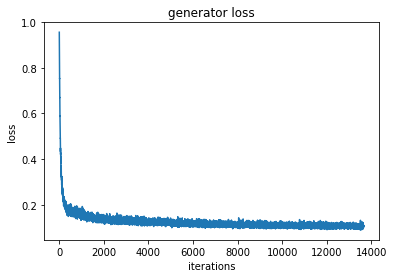

Step 13660: dloss = 0.9116, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.9116, gan_loss = 18369.5996 l1_loss = 0.0850
Step 13670: dloss = 0.8787, gloss = 0.1015, real_loss = 0.0000, fake_loss = 0.8787, gan_loss = 18806.5723 l1_loss = 0.0827
Step 13680: dloss = 0.9048, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.9048, gan_loss = 18504.3750 l1_loss = 0.0847
Step 13690: dloss = 0.9233, gloss = 0.1105, real_loss = 0.0336, fake_loss = 0.8897, gan_loss = 18698.2480 l1_loss = 0.0918
Step 13700: dloss = 1.1318, gloss = 0.1118, real_loss = 0.2336, fake_loss = 0.8982, gan_loss = 19110.0762 l1_loss = 0.0927
Step 13710: dloss = 1.2821, gloss = 0.1021, real_loss = 0.4073, fake_loss = 0.8748, gan_loss = 18367.6094 l1_loss = 0.0838
Step 13720: dloss = 0.9253, gloss = 0.1142, real_loss = 0.0314, fake_loss = 0.8940, gan_loss = 18663.8613 l1_loss = 0.0955
Step 13730: dloss = 0.8625, gloss = 0.0973, real_loss = 0.0035, fake_loss = 0.8590, gan_loss = 18071.3770 l1_loss = 0.0792
Step 13740: dlos

Step 14330: dloss = 0.8790, gloss = 0.1034, real_loss = 0.0000, fake_loss = 0.8790, gan_loss = 18404.6328 l1_loss = 0.0850
Step 14340: dloss = 0.8678, gloss = 0.1040, real_loss = 0.0000, fake_loss = 0.8678, gan_loss = 19172.2500 l1_loss = 0.0849
Step 14350: dloss = 0.8794, gloss = 0.1008, real_loss = 0.0000, fake_loss = 0.8794, gan_loss = 18507.2910 l1_loss = 0.0823
Step 14360: dloss = 0.9589, gloss = 0.1093, real_loss = 0.0500, fake_loss = 0.9089, gan_loss = 17771.4141 l1_loss = 0.0915
Step 14370: dloss = 0.9017, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.9017, gan_loss = 19002.6602 l1_loss = 0.0814
Step 14380: dloss = 1.1694, gloss = 0.1138, real_loss = 0.2610, fake_loss = 0.9084, gan_loss = 18775.8867 l1_loss = 0.0951
Step 14390: dloss = 1.6373, gloss = 0.1065, real_loss = 0.7544, fake_loss = 0.8829, gan_loss = 18554.0039 l1_loss = 0.0880
Step 14400: dloss = 0.9162, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.9162, gan_loss = 17962.8926 l1_loss = 0.0816
Step 14410: dlos

Step 15000: dloss = 0.9030, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.9030, gan_loss = 18734.2070 l1_loss = 0.0805
Step 15010: dloss = 0.8947, gloss = 0.1001, real_loss = 0.0015, fake_loss = 0.8932, gan_loss = 17989.5020 l1_loss = 0.0821
Step 15020: dloss = 0.8765, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8765, gan_loss = 17763.0840 l1_loss = 0.0853
Step 15030: dloss = 1.2287, gloss = 0.1017, real_loss = 0.3500, fake_loss = 0.8787, gan_loss = 18378.5117 l1_loss = 0.0833
Step 15040: dloss = 0.8643, gloss = 0.1049, real_loss = 0.0000, fake_loss = 0.8643, gan_loss = 18620.2188 l1_loss = 0.0863
Step 15050: dloss = 1.5248, gloss = 0.1067, real_loss = 0.6326, fake_loss = 0.8922, gan_loss = 18643.8809 l1_loss = 0.0881
Step 15060: dloss = 1.4294, gloss = 0.1056, real_loss = 0.5513, fake_loss = 0.8781, gan_loss = 18860.8711 l1_loss = 0.0867
Step 15070: dloss = 0.9040, gloss = 0.1043, real_loss = 0.0131, fake_loss = 0.8909, gan_loss = 18068.2246 l1_loss = 0.0862
Step 15080: dlos

Step 15670: dloss = 0.9194, gloss = 0.1065, real_loss = 0.0060, fake_loss = 0.9134, gan_loss = 18185.6719 l1_loss = 0.0883
Step 15680: dloss = 0.8854, gloss = 0.1093, real_loss = 0.0000, fake_loss = 0.8854, gan_loss = 18937.1719 l1_loss = 0.0904
Step 15690: dloss = 0.8570, gloss = 0.1089, real_loss = 0.0000, fake_loss = 0.8570, gan_loss = 18447.4902 l1_loss = 0.0904
Step 15700: dloss = 1.0308, gloss = 0.1007, real_loss = 0.1696, fake_loss = 0.8612, gan_loss = 17322.4668 l1_loss = 0.0834
Step 15710: dloss = 0.8979, gloss = 0.1076, real_loss = 0.0000, fake_loss = 0.8979, gan_loss = 18344.2188 l1_loss = 0.0892
Step 15720: dloss = 1.0635, gloss = 0.0985, real_loss = 0.1483, fake_loss = 0.9151, gan_loss = 18327.2285 l1_loss = 0.0801
Step 15730: dloss = 0.9103, gloss = 0.1108, real_loss = 0.0000, fake_loss = 0.9103, gan_loss = 18107.6172 l1_loss = 0.0927
Step 15740: dloss = 0.9051, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.9051, gan_loss = 18591.8867 l1_loss = 0.0806
Step 15750: dlos

Step 16340: dloss = 1.3032, gloss = 0.1149, real_loss = 0.4046, fake_loss = 0.8986, gan_loss = 17372.1387 l1_loss = 0.0976
Step 16350: dloss = 1.4843, gloss = 0.0971, real_loss = 0.5349, fake_loss = 0.9494, gan_loss = 18822.1836 l1_loss = 0.0783
Step 16360: dloss = 1.1314, gloss = 0.1114, real_loss = 0.2123, fake_loss = 0.9191, gan_loss = 17893.6484 l1_loss = 0.0936
Step 16370: dloss = 1.8426, gloss = 0.1065, real_loss = 0.9692, fake_loss = 0.8734, gan_loss = 18858.6895 l1_loss = 0.0876
Step 16380: dloss = 0.9891, gloss = 0.1076, real_loss = 0.0971, fake_loss = 0.8920, gan_loss = 17882.7754 l1_loss = 0.0897
Epoch 5: dis loss = 0.9891, gen loss = 0.1076, real_label_loss = 0.0971, fake_label_loss = 0.8920


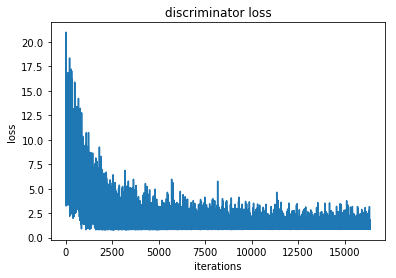

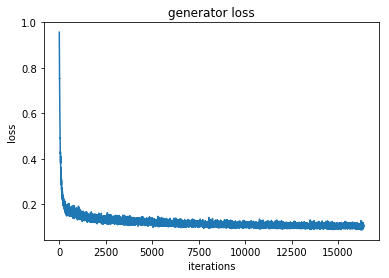

Step 16390: dloss = 1.4353, gloss = 0.1038, real_loss = 0.5566, fake_loss = 0.8786, gan_loss = 18456.9590 l1_loss = 0.0854
Step 16400: dloss = 0.9121, gloss = 0.1023, real_loss = 0.0000, fake_loss = 0.9121, gan_loss = 18834.4668 l1_loss = 0.0834
Step 16410: dloss = 1.4736, gloss = 0.1024, real_loss = 0.5763, fake_loss = 0.8973, gan_loss = 18344.0918 l1_loss = 0.0841
Step 16420: dloss = 0.8667, gloss = 0.1102, real_loss = 0.0000, fake_loss = 0.8667, gan_loss = 18451.4082 l1_loss = 0.0917
Step 16430: dloss = 1.8894, gloss = 0.1100, real_loss = 1.0466, fake_loss = 0.8429, gan_loss = 18691.7148 l1_loss = 0.0913
Step 16440: dloss = 0.8800, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.8800, gan_loss = 18864.0195 l1_loss = 0.0793
Step 16450: dloss = 0.8282, gloss = 0.1112, real_loss = 0.0000, fake_loss = 0.8282, gan_loss = 18496.9141 l1_loss = 0.0927
Step 16460: dloss = 0.8635, gloss = 0.0954, real_loss = 0.0000, fake_loss = 0.8635, gan_loss = 18216.1641 l1_loss = 0.0772
Step 16470: dlos

Step 17060: dloss = 0.9683, gloss = 0.1017, real_loss = 0.0776, fake_loss = 0.8907, gan_loss = 18593.7520 l1_loss = 0.0831
Step 17070: dloss = 0.8725, gloss = 0.0992, real_loss = 0.0000, fake_loss = 0.8725, gan_loss = 17910.3789 l1_loss = 0.0813
Step 17080: dloss = 0.9215, gloss = 0.0982, real_loss = 0.0000, fake_loss = 0.9215, gan_loss = 18170.2109 l1_loss = 0.0800
Step 17090: dloss = 1.9414, gloss = 0.1095, real_loss = 1.0370, fake_loss = 0.9045, gan_loss = 18901.8691 l1_loss = 0.0906
Step 17100: dloss = 0.8941, gloss = 0.0989, real_loss = 0.0000, fake_loss = 0.8941, gan_loss = 18899.2598 l1_loss = 0.0800
Step 17110: dloss = 1.8018, gloss = 0.1124, real_loss = 0.9234, fake_loss = 0.8784, gan_loss = 18725.2441 l1_loss = 0.0937
Step 17120: dloss = 0.8663, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8663, gan_loss = 18328.3242 l1_loss = 0.0869
Step 17130: dloss = 0.9073, gloss = 0.0988, real_loss = 0.0000, fake_loss = 0.9073, gan_loss = 19196.3691 l1_loss = 0.0796
Step 17140: dlos

Step 17730: dloss = 0.9081, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.9081, gan_loss = 18791.4766 l1_loss = 0.0806
Step 17740: dloss = 0.8590, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8590, gan_loss = 18021.8477 l1_loss = 0.0814
Step 17750: dloss = 0.8990, gloss = 0.1023, real_loss = 0.0208, fake_loss = 0.8783, gan_loss = 18770.3203 l1_loss = 0.0835
Step 17760: dloss = 0.8800, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8800, gan_loss = 18451.9414 l1_loss = 0.0822
Step 17770: dloss = 0.9194, gloss = 0.1045, real_loss = 0.0220, fake_loss = 0.8975, gan_loss = 18579.4414 l1_loss = 0.0859
Step 17780: dloss = 0.8691, gloss = 0.1052, real_loss = 0.0000, fake_loss = 0.8691, gan_loss = 18594.1543 l1_loss = 0.0866
Step 17790: dloss = 1.5074, gloss = 0.1020, real_loss = 0.6085, fake_loss = 0.8989, gan_loss = 17812.4824 l1_loss = 0.0842
Step 17800: dloss = 0.8704, gloss = 0.1022, real_loss = 0.0000, fake_loss = 0.8704, gan_loss = 18181.3359 l1_loss = 0.0841
Step 17810: dlos

Step 18400: dloss = 1.3739, gloss = 0.1037, real_loss = 0.4782, fake_loss = 0.8957, gan_loss = 18057.2715 l1_loss = 0.0856
Step 18410: dloss = 0.8905, gloss = 0.1053, real_loss = 0.0000, fake_loss = 0.8905, gan_loss = 17764.0645 l1_loss = 0.0875
Step 18420: dloss = 1.5187, gloss = 0.1095, real_loss = 0.6202, fake_loss = 0.8986, gan_loss = 18735.8613 l1_loss = 0.0907
Step 18430: dloss = 0.8775, gloss = 0.0990, real_loss = 0.0000, fake_loss = 0.8775, gan_loss = 18198.4805 l1_loss = 0.0808
Step 18440: dloss = 1.0763, gloss = 0.1061, real_loss = 0.1737, fake_loss = 0.9026, gan_loss = 18784.9336 l1_loss = 0.0873
Step 18450: dloss = 0.8769, gloss = 0.0973, real_loss = 0.0000, fake_loss = 0.8769, gan_loss = 18298.8535 l1_loss = 0.0790
Step 18460: dloss = 0.8780, gloss = 0.1101, real_loss = 0.0000, fake_loss = 0.8780, gan_loss = 18679.9668 l1_loss = 0.0914
Step 18470: dloss = 0.8726, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8726, gan_loss = 17492.1426 l1_loss = 0.0784
Step 18480: dlos

Step 19070: dloss = 0.8813, gloss = 0.1146, real_loss = 0.0000, fake_loss = 0.8813, gan_loss = 17961.4141 l1_loss = 0.0966
Step 19080: dloss = 1.0890, gloss = 0.0951, real_loss = 0.1919, fake_loss = 0.8971, gan_loss = 18486.7852 l1_loss = 0.0767
Step 19090: dloss = 0.8689, gloss = 0.1108, real_loss = 0.0000, fake_loss = 0.8689, gan_loss = 18771.6543 l1_loss = 0.0920
Step 19100: dloss = 0.8975, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.8975, gan_loss = 18517.3145 l1_loss = 0.0861
Step 19110: dloss = 1.1768, gloss = 0.1063, real_loss = 0.3144, fake_loss = 0.8624, gan_loss = 18626.4160 l1_loss = 0.0877
Epoch 6: dis loss = 1.1768, gen loss = 0.1063, real_label_loss = 0.3144, fake_label_loss = 0.8624


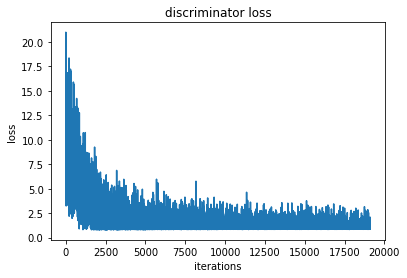

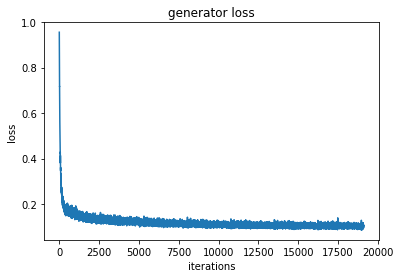

Step 19120: dloss = 0.8687, gloss = 0.1028, real_loss = 0.0001, fake_loss = 0.8687, gan_loss = 18173.1348 l1_loss = 0.0847
Step 19130: dloss = 0.8594, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.8594, gan_loss = 18471.2441 l1_loss = 0.0820
Step 19140: dloss = 0.9115, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.9115, gan_loss = 18705.5859 l1_loss = 0.0829
Step 19150: dloss = 1.3131, gloss = 0.1076, real_loss = 0.4275, fake_loss = 0.8856, gan_loss = 18731.5410 l1_loss = 0.0888
Step 19160: dloss = 0.8839, gloss = 0.1075, real_loss = 0.0002, fake_loss = 0.8837, gan_loss = 18801.1738 l1_loss = 0.0887
Step 19170: dloss = 1.7490, gloss = 0.0982, real_loss = 0.8529, fake_loss = 0.8962, gan_loss = 18123.9688 l1_loss = 0.0800
Step 19180: dloss = 2.0855, gloss = 0.1105, real_loss = 1.1864, fake_loss = 0.8990, gan_loss = 18441.5293 l1_loss = 0.0920
Step 19190: dloss = 0.9740, gloss = 0.0946, real_loss = 0.0690, fake_loss = 0.9050, gan_loss = 18342.0273 l1_loss = 0.0763
Step 19200: dlos

Step 19790: dloss = 0.8994, gloss = 0.1007, real_loss = 0.0000, fake_loss = 0.8994, gan_loss = 18467.2930 l1_loss = 0.0822
Step 19800: dloss = 1.5532, gloss = 0.0983, real_loss = 0.6744, fake_loss = 0.8788, gan_loss = 17788.8359 l1_loss = 0.0805
Step 19810: dloss = 0.8984, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8984, gan_loss = 18209.9375 l1_loss = 0.0798
Step 19820: dloss = 1.0890, gloss = 0.1078, real_loss = 0.1823, fake_loss = 0.9067, gan_loss = 18629.1074 l1_loss = 0.0892
Step 19830: dloss = 1.8514, gloss = 0.0969, real_loss = 0.9785, fake_loss = 0.8729, gan_loss = 18581.7617 l1_loss = 0.0783
Step 19840: dloss = 0.8838, gloss = 0.1098, real_loss = 0.0000, fake_loss = 0.8838, gan_loss = 17424.6855 l1_loss = 0.0924
Step 19850: dloss = 0.8750, gloss = 0.1033, real_loss = 0.0000, fake_loss = 0.8750, gan_loss = 16929.9863 l1_loss = 0.0864
Step 19860: dloss = 0.8804, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.8804, gan_loss = 18435.3398 l1_loss = 0.0796
Step 19870: dlos

Step 20460: dloss = 0.8961, gloss = 0.0980, real_loss = 0.0219, fake_loss = 0.8742, gan_loss = 18834.4473 l1_loss = 0.0791
Step 20470: dloss = 0.8732, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.8732, gan_loss = 17938.8047 l1_loss = 0.0796
Step 20480: dloss = 0.9136, gloss = 0.1010, real_loss = 0.0000, fake_loss = 0.9136, gan_loss = 17918.9961 l1_loss = 0.0831
Step 20490: dloss = 0.8803, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.8803, gan_loss = 18743.5820 l1_loss = 0.0806
Step 20500: dloss = 0.9021, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.9021, gan_loss = 19091.9023 l1_loss = 0.0836
Step 20510: dloss = 0.8855, gloss = 0.1045, real_loss = 0.0000, fake_loss = 0.8855, gan_loss = 18373.8906 l1_loss = 0.0861
Step 20520: dloss = 0.8539, gloss = 0.1025, real_loss = 0.0000, fake_loss = 0.8539, gan_loss = 18162.3984 l1_loss = 0.0843
Step 20530: dloss = 0.8686, gloss = 0.1004, real_loss = 0.0000, fake_loss = 0.8686, gan_loss = 18267.8672 l1_loss = 0.0821
Step 20540: dlos

Step 21130: dloss = 0.8678, gloss = 0.1030, real_loss = 0.0000, fake_loss = 0.8677, gan_loss = 17927.3066 l1_loss = 0.0850
Step 21140: dloss = 1.1048, gloss = 0.1041, real_loss = 0.2149, fake_loss = 0.8899, gan_loss = 18057.6484 l1_loss = 0.0860
Step 21150: dloss = 0.9083, gloss = 0.1030, real_loss = 0.0001, fake_loss = 0.9083, gan_loss = 17484.4805 l1_loss = 0.0856
Step 21160: dloss = 1.2203, gloss = 0.0957, real_loss = 0.3206, fake_loss = 0.8998, gan_loss = 18464.7715 l1_loss = 0.0773
Step 21170: dloss = 0.9092, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.9092, gan_loss = 18430.3906 l1_loss = 0.0862
Step 21180: dloss = 0.8773, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.8773, gan_loss = 17223.6660 l1_loss = 0.0776
Step 21190: dloss = 0.9126, gloss = 0.1090, real_loss = 0.0170, fake_loss = 0.8956, gan_loss = 18709.9863 l1_loss = 0.0903
Step 21200: dloss = 0.8657, gloss = 0.0956, real_loss = 0.0000, fake_loss = 0.8657, gan_loss = 18473.8008 l1_loss = 0.0771
Step 21210: dlos

Step 21800: dloss = 1.2782, gloss = 0.1132, real_loss = 0.3702, fake_loss = 0.9081, gan_loss = 18552.3164 l1_loss = 0.0946
Step 21810: dloss = 1.5575, gloss = 0.0946, real_loss = 0.6652, fake_loss = 0.8923, gan_loss = 18378.9199 l1_loss = 0.0762
Step 21820: dloss = 1.0008, gloss = 0.1093, real_loss = 0.1239, fake_loss = 0.8769, gan_loss = 18598.0527 l1_loss = 0.0907
Step 21830: dloss = 1.2586, gloss = 0.1024, real_loss = 0.3852, fake_loss = 0.8735, gan_loss = 18203.3145 l1_loss = 0.0842
Step 21840: dloss = 0.9091, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.9091, gan_loss = 18643.0449 l1_loss = 0.0853
Epoch 7: dis loss = 0.9091, gen loss = 0.1039, real_label_loss = 0.0000, fake_label_loss = 0.9091


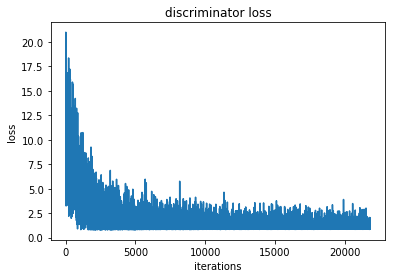

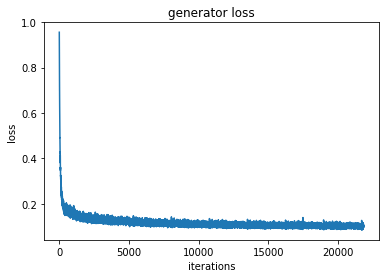

Step 21850: dloss = 0.8928, gloss = 0.1019, real_loss = 0.0008, fake_loss = 0.8919, gan_loss = 18457.8457 l1_loss = 0.0834
Step 21860: dloss = 0.8642, gloss = 0.0995, real_loss = 0.0000, fake_loss = 0.8642, gan_loss = 18724.6348 l1_loss = 0.0808
Step 21870: dloss = 0.8702, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8702, gan_loss = 17896.3066 l1_loss = 0.0822
Step 21880: dloss = 0.8938, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8938, gan_loss = 17761.0449 l1_loss = 0.0884
Step 21890: dloss = 0.8867, gloss = 0.1054, real_loss = 0.0000, fake_loss = 0.8867, gan_loss = 18291.8828 l1_loss = 0.0871
Step 21900: dloss = 0.8538, gloss = 0.0977, real_loss = 0.0000, fake_loss = 0.8538, gan_loss = 18511.8594 l1_loss = 0.0792
Step 21910: dloss = 1.6847, gloss = 0.1089, real_loss = 0.8217, fake_loss = 0.8631, gan_loss = 18595.2090 l1_loss = 0.0903
Step 21920: dloss = 0.9084, gloss = 0.0936, real_loss = 0.0000, fake_loss = 0.9084, gan_loss = 18452.6562 l1_loss = 0.0752
Step 21930: dlos

Step 22520: dloss = 0.9013, gloss = 0.0994, real_loss = 0.0000, fake_loss = 0.9013, gan_loss = 18467.1230 l1_loss = 0.0810
Step 22530: dloss = 0.9154, gloss = 0.0976, real_loss = 0.0000, fake_loss = 0.9154, gan_loss = 18022.8555 l1_loss = 0.0795
Step 22540: dloss = 1.1934, gloss = 0.0975, real_loss = 0.2907, fake_loss = 0.9027, gan_loss = 18441.1914 l1_loss = 0.0791
Step 22550: dloss = 0.8933, gloss = 0.1062, real_loss = 0.0000, fake_loss = 0.8933, gan_loss = 18062.9102 l1_loss = 0.0882
Step 22560: dloss = 0.9039, gloss = 0.0964, real_loss = 0.0114, fake_loss = 0.8926, gan_loss = 19112.7285 l1_loss = 0.0773
Step 22570: dloss = 0.8705, gloss = 0.1094, real_loss = 0.0000, fake_loss = 0.8705, gan_loss = 17796.4746 l1_loss = 0.0916
Step 22580: dloss = 0.9120, gloss = 0.1045, real_loss = 0.0334, fake_loss = 0.8787, gan_loss = 19246.9785 l1_loss = 0.0852
Step 22590: dloss = 2.4972, gloss = 0.0963, real_loss = 1.6150, fake_loss = 0.8823, gan_loss = 17561.4297 l1_loss = 0.0788
Step 22600: dlos

Step 23190: dloss = 0.8930, gloss = 0.0979, real_loss = 0.0000, fake_loss = 0.8929, gan_loss = 18559.0977 l1_loss = 0.0793
Step 23200: dloss = 1.1910, gloss = 0.0955, real_loss = 0.2830, fake_loss = 0.9079, gan_loss = 17528.7852 l1_loss = 0.0780
Step 23210: dloss = 1.8419, gloss = 0.0977, real_loss = 0.9527, fake_loss = 0.8892, gan_loss = 18051.2148 l1_loss = 0.0796
Step 23220: dloss = 0.8448, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8448, gan_loss = 18369.4336 l1_loss = 0.0797
Step 23230: dloss = 0.8970, gloss = 0.1026, real_loss = 0.0000, fake_loss = 0.8970, gan_loss = 18711.8516 l1_loss = 0.0839
Step 23240: dloss = 0.8804, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8804, gan_loss = 18313.1230 l1_loss = 0.0843
Step 23250: dloss = 1.8572, gloss = 0.0997, real_loss = 0.9704, fake_loss = 0.8868, gan_loss = 18208.4570 l1_loss = 0.0815
Step 23260: dloss = 0.8957, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8957, gan_loss = 18502.1133 l1_loss = 0.0814
Step 23270: dlos

Step 23860: dloss = 0.9035, gloss = 0.1037, real_loss = 0.0001, fake_loss = 0.9034, gan_loss = 18778.0195 l1_loss = 0.0850
Step 23870: dloss = 0.9202, gloss = 0.1039, real_loss = 0.0000, fake_loss = 0.9202, gan_loss = 17755.4805 l1_loss = 0.0861
Step 23880: dloss = 0.9133, gloss = 0.1059, real_loss = 0.0000, fake_loss = 0.9133, gan_loss = 18600.8516 l1_loss = 0.0873
Step 23890: dloss = 0.8811, gloss = 0.0971, real_loss = 0.0009, fake_loss = 0.8802, gan_loss = 17775.6992 l1_loss = 0.0793
Step 23900: dloss = 0.8426, gloss = 0.1052, real_loss = 0.0036, fake_loss = 0.8390, gan_loss = 18696.5000 l1_loss = 0.0865
Step 23910: dloss = 0.9175, gloss = 0.0957, real_loss = 0.0000, fake_loss = 0.9175, gan_loss = 18595.2598 l1_loss = 0.0771
Step 23920: dloss = 0.8581, gloss = 0.1087, real_loss = 0.0000, fake_loss = 0.8581, gan_loss = 18589.4102 l1_loss = 0.0901
Step 23930: dloss = 0.8915, gloss = 0.0960, real_loss = 0.0000, fake_loss = 0.8915, gan_loss = 18567.4805 l1_loss = 0.0775
Step 23940: dlos

Step 24530: dloss = 0.8996, gloss = 0.1106, real_loss = 0.0002, fake_loss = 0.8995, gan_loss = 17501.3711 l1_loss = 0.0931
Step 24540: dloss = 0.9154, gloss = 0.0937, real_loss = 0.0000, fake_loss = 0.9154, gan_loss = 17897.4375 l1_loss = 0.0758
Step 24550: dloss = 0.8859, gloss = 0.1077, real_loss = 0.0000, fake_loss = 0.8859, gan_loss = 18745.7480 l1_loss = 0.0890
Step 24560: dloss = 0.9203, gloss = 0.1005, real_loss = 0.0000, fake_loss = 0.9203, gan_loss = 17847.6953 l1_loss = 0.0827
Step 24570: dloss = 0.8637, gloss = 0.1019, real_loss = 0.0000, fake_loss = 0.8637, gan_loss = 17651.0645 l1_loss = 0.0843
Epoch 8: dis loss = 0.8637, gen loss = 0.1019, real_label_loss = 0.0000, fake_label_loss = 0.8637


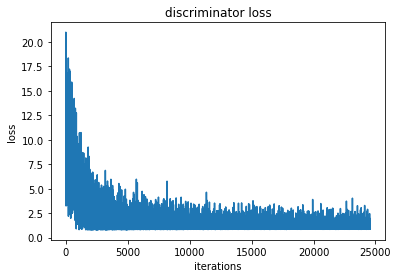

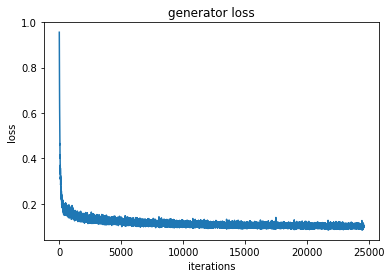

Step 24580: dloss = 0.8973, gloss = 0.1000, real_loss = 0.0000, fake_loss = 0.8973, gan_loss = 18626.2793 l1_loss = 0.0814
Step 24590: dloss = 1.0056, gloss = 0.0984, real_loss = 0.0904, fake_loss = 0.9153, gan_loss = 18448.3398 l1_loss = 0.0799
Step 24600: dloss = 0.8872, gloss = 0.0999, real_loss = 0.0000, fake_loss = 0.8872, gan_loss = 18842.4941 l1_loss = 0.0811
Step 24610: dloss = 0.8978, gloss = 0.1055, real_loss = 0.0000, fake_loss = 0.8978, gan_loss = 18532.1270 l1_loss = 0.0870
Step 24620: dloss = 0.8690, gloss = 0.1048, real_loss = 0.0000, fake_loss = 0.8690, gan_loss = 18584.5957 l1_loss = 0.0862
Step 24630: dloss = 1.2301, gloss = 0.0958, real_loss = 0.3532, fake_loss = 0.8769, gan_loss = 18258.8047 l1_loss = 0.0776
Step 24640: dloss = 0.9117, gloss = 0.1067, real_loss = 0.0000, fake_loss = 0.9117, gan_loss = 18107.2402 l1_loss = 0.0886
Step 24650: dloss = 0.9562, gloss = 0.0921, real_loss = 0.0425, fake_loss = 0.9136, gan_loss = 18423.4043 l1_loss = 0.0736
Step 24660: dlos

Step 25250: dloss = 0.8734, gloss = 0.0991, real_loss = 0.0000, fake_loss = 0.8734, gan_loss = 18394.7305 l1_loss = 0.0807
Step 25260: dloss = 0.9034, gloss = 0.0958, real_loss = 0.0001, fake_loss = 0.9033, gan_loss = 17911.8652 l1_loss = 0.0779
Step 25270: dloss = 0.9352, gloss = 0.0966, real_loss = 0.0671, fake_loss = 0.8681, gan_loss = 18566.9668 l1_loss = 0.0781
Step 25280: dloss = 1.3692, gloss = 0.1038, real_loss = 0.4915, fake_loss = 0.8777, gan_loss = 18207.5527 l1_loss = 0.0856
Step 25290: dloss = 0.9120, gloss = 0.0948, real_loss = 0.0000, fake_loss = 0.9120, gan_loss = 18315.4551 l1_loss = 0.0765
Step 25300: dloss = 1.1930, gloss = 0.1079, real_loss = 0.3155, fake_loss = 0.8775, gan_loss = 17046.9746 l1_loss = 0.0908
Step 25310: dloss = 0.8984, gloss = 0.1027, real_loss = 0.0000, fake_loss = 0.8984, gan_loss = 18444.7031 l1_loss = 0.0843
Step 25320: dloss = 0.8821, gloss = 0.0966, real_loss = 0.0000, fake_loss = 0.8821, gan_loss = 18106.3672 l1_loss = 0.0785
Step 25330: dlos

Step 25920: dloss = 0.8962, gloss = 0.0959, real_loss = 0.0000, fake_loss = 0.8962, gan_loss = 18355.1914 l1_loss = 0.0775
Step 25930: dloss = 0.9184, gloss = 0.0944, real_loss = 0.0005, fake_loss = 0.9179, gan_loss = 18194.6270 l1_loss = 0.0763
Step 25940: dloss = 0.9136, gloss = 0.0980, real_loss = 0.0000, fake_loss = 0.9136, gan_loss = 17472.8672 l1_loss = 0.0805
Step 25950: dloss = 1.1616, gloss = 0.0962, real_loss = 0.2402, fake_loss = 0.9213, gan_loss = 17239.8711 l1_loss = 0.0790
Step 25960: dloss = 1.0019, gloss = 0.1010, real_loss = 0.0723, fake_loss = 0.9296, gan_loss = 18493.9512 l1_loss = 0.0826
Step 25970: dloss = 0.8691, gloss = 0.1016, real_loss = 0.0000, fake_loss = 0.8691, gan_loss = 18101.7969 l1_loss = 0.0835
Step 25980: dloss = 0.9053, gloss = 0.0987, real_loss = 0.0001, fake_loss = 0.9052, gan_loss = 18297.0508 l1_loss = 0.0804
Step 25990: dloss = 0.8951, gloss = 0.0981, real_loss = 0.0000, fake_loss = 0.8951, gan_loss = 17892.8027 l1_loss = 0.0802
Step 26000: dlos

Step 26590: dloss = 1.1525, gloss = 0.1011, real_loss = 0.2915, fake_loss = 0.8609, gan_loss = 17363.3066 l1_loss = 0.0837
Step 26600: dloss = 0.9131, gloss = 0.1032, real_loss = 0.0000, fake_loss = 0.9131, gan_loss = 18265.1367 l1_loss = 0.0849
Step 26610: dloss = 0.9093, gloss = 0.1046, real_loss = 0.0000, fake_loss = 0.9093, gan_loss = 18527.2930 l1_loss = 0.0861
Step 26620: dloss = 1.8240, gloss = 0.0981, real_loss = 0.9441, fake_loss = 0.8799, gan_loss = 18774.5234 l1_loss = 0.0794
Step 26630: dloss = 1.1080, gloss = 0.1031, real_loss = 0.2159, fake_loss = 0.8921, gan_loss = 18330.8027 l1_loss = 0.0847
Step 26640: dloss = 0.8738, gloss = 0.0942, real_loss = 0.0000, fake_loss = 0.8738, gan_loss = 18482.4297 l1_loss = 0.0758
Step 26650: dloss = 0.9070, gloss = 0.1066, real_loss = 0.0000, fake_loss = 0.9070, gan_loss = 18412.9336 l1_loss = 0.0882
Step 26660: dloss = 0.8818, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.8818, gan_loss = 18229.6055 l1_loss = 0.0753
Step 26670: dlos

Step 27260: dloss = 0.8666, gloss = 0.1114, real_loss = 0.0000, fake_loss = 0.8666, gan_loss = 18344.0410 l1_loss = 0.0931
Step 27270: dloss = 0.8765, gloss = 0.0935, real_loss = 0.0000, fake_loss = 0.8765, gan_loss = 18723.5000 l1_loss = 0.0748
Step 27280: dloss = 0.8764, gloss = 0.1069, real_loss = 0.0000, fake_loss = 0.8764, gan_loss = 18516.5039 l1_loss = 0.0884
Step 27290: dloss = 0.8872, gloss = 0.1006, real_loss = 0.0000, fake_loss = 0.8872, gan_loss = 18178.2480 l1_loss = 0.0825
Step 27300: dloss = 0.8716, gloss = 0.1016, real_loss = 0.0006, fake_loss = 0.8710, gan_loss = 18554.7969 l1_loss = 0.0830
Epoch 9: dis loss = 0.8716, gen loss = 0.1016, real_label_loss = 0.0006, fake_label_loss = 0.8710


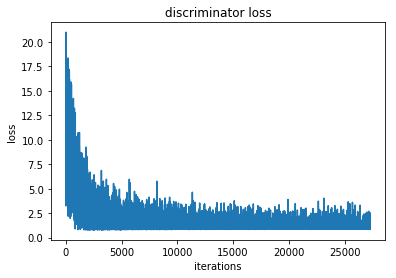

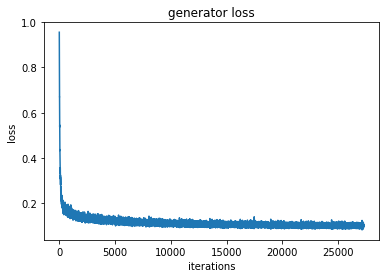

In [23]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
total_images = len(train_pairs)
step = 0

r = total_images // batch_size
l = len(dataset_train) // batch_size

dis_losses = []
gen_losses = []




'''
local margin = 0.3
     sgdState_D.optimize = true
     sgdState_G.optimize = true
if err_F < margin or err_R < margin then
     sgdState_D.optimize = false
end
if err_F > (1.0-margin) or err_R > (1.0-margin) then
     sgdState_G.optimize = false
end
if sgdState_G.optimize == false and sgdState_D.optimize == false then
     sgdState_G.optimize = true
     sgdState_D.optimize = true
end
'''


real_m, fake_m = 0.2, 0.2
margin = 0.3 #(0.1*0.3 + 0.1 = 0.13)
doptim, goptim = True, True
_fake, _real = 0.5, 0.5
gen_loss = 1.0
dis_los = 0.5

gen_gan_t = 0.06
gan = 1.0

g_threshold = 0.13



for epoch in range(epochs):
    for ii in range(r):
        step += 1
        #zeros = np.zeros([batch_size, 1])* ((np.random.random_sample() *0.4) - 0.2)
        zeros = np.zeros([batch_size, 1])
        ones = np.ones([batch_size, 1]) * ((np.random.random_sample() *0.5) + 0.7)
        
        d_pairs = train_pairs[ii*batch_size : (ii+1)*batch_size]
        batch, batch_labels, pose_labels = get_batch_data(d_pairs)

        
        k = np.random.randint(1,l-1)
        d_inputs = dataset_train[k*batch_size : (k+1)*batch_size]
        
        feed_dict = {inputs_: batch, targets_: batch_labels, pose_: pose_labels,
                    fake_label: zeros, real_label: ones, disc_inputs: d_inputs}
        fetch_val = [gen_loss_op, dis_loss_op, dreal_loss, dfake_loss, gan_loss, supervised_loss]
            
        #if _fake > (1.0 - fake_m) or _real > (1.0 - real_m):
        #    goptim = False
        
        #if gen_loss < 0.34:
        #    goptim = False
            
        #if gen_loss > margin
        
        #if _real < real_m or _fake < fake_m or dis_los < margin:
        #    doptim = False
            
        #if gen_loss < (g_threshold):
        #    goptim = False
        
        #if gan < gen_gan_t:
        #    goptim = False
            
        #if goptim == False and doptim == False:
        #    goptim, doptim = True, True
        
        if step % 5 or _real < real_m or _fake < fake_m or dis_los < margin: # biased towards generator
            fetch_val.append(gen_train_op)
        else:
            fetch_val.append(dis_train_op) 
        
        
        gen_loss, dis_loss, _real, _fake, gan, superl,_ = sess.run(fetch_val, feed_dict = feed_dict)

        dis_losses.append(dis_loss)
        gen_losses.append(gen_loss)
        
        #print(goptim, doptim)

        if step % 10 == 0:
            print('Step {0}: dloss = {1:.4f}, gloss = {2:.4f}, real_loss = {3:.4f}, fake_loss = {4:.4f}, gan_loss = {5:.4f} l1_loss = {6:.4f}'.format(step, dis_loss, gen_loss, _real, _fake, gan, superl))
            
    print('Epoch {0}: dis loss = {1:.4f}, gen loss = {2:.4f}, real_label_loss = {3:.4f}, fake_label_loss = {4:.4f}'.format(epoch, dis_loss, gen_loss, _real, _fake))
    plt.plot(dis_losses)
    plt.title('discriminator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

    plt.plot(gen_losses)
    plt.title('generator loss')
    plt.xlabel('iterations')
    plt.ylabel('loss')
    plt.show()

In [24]:
dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'encoder')
saver = tf.train.Saver(dis_var_list + gen_var_list)
saver.save(sess, 'model/dcgan_pose_car_op_one_pose')

'model/dcgan_pose_car_op_one_pose'

In [25]:
d_pairs = test_pairs[5 * batch_size : 6 * batch_size]
test_batch, test_labels, test_pose = get_batch_data(d_pairs, False)

In [26]:
feed_dict = { inputs_: test_batch, pose_: test_pose}
op = sess.run([generated_images], feed_dict = feed_dict)

In [27]:
j = 20
op = denormalize(op[0])



In [28]:
#op = op.astype(np.uint8)
print(np.min(op), np.max(op))
#print(np.where(op < -0.00001 ))

#print(op[0][0][59])

0.0 255.0


In [29]:
op = np.where(op < 0.0,0.0, op)

In [30]:
print(np.min(op), np.max(op))

0.0 255.0


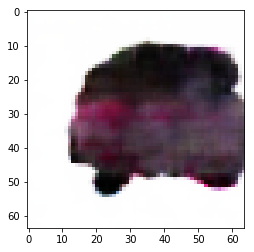

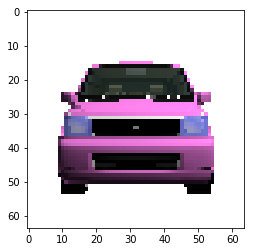

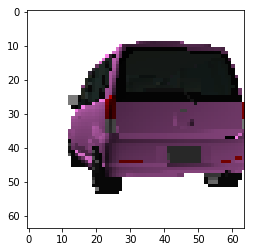

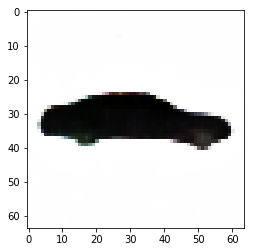

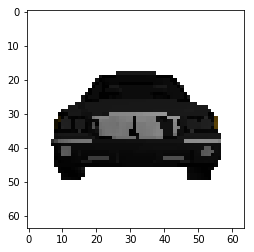

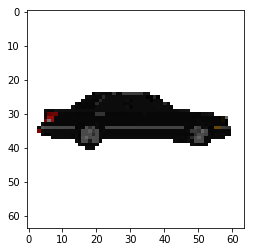

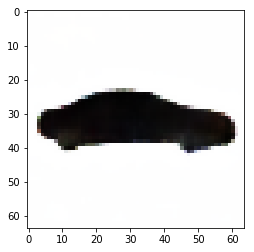

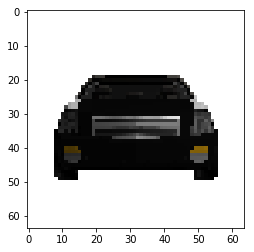

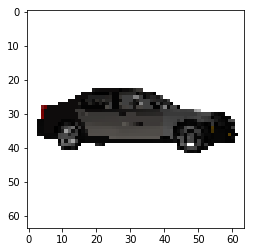

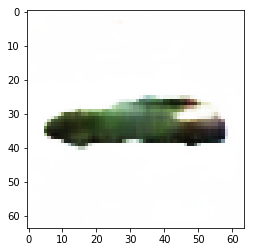

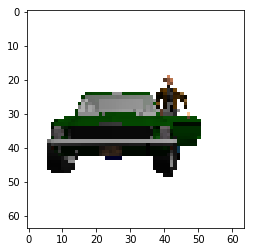

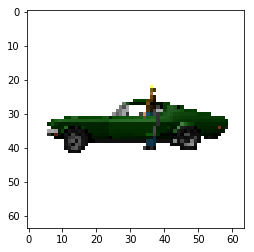

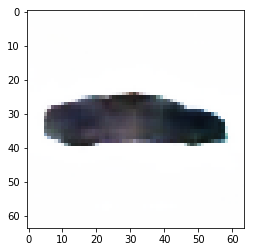

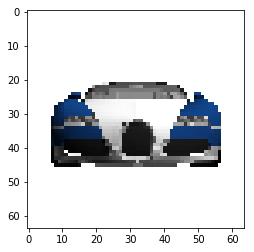

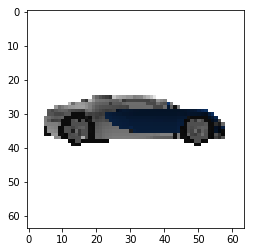

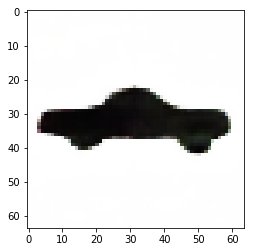

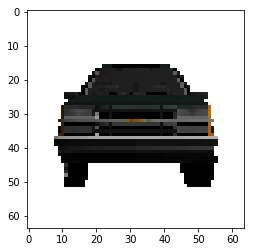

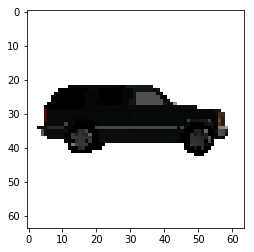

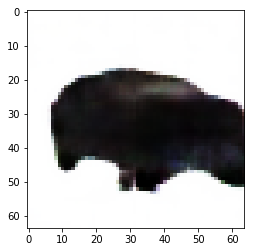

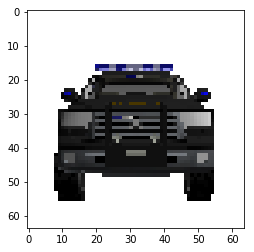

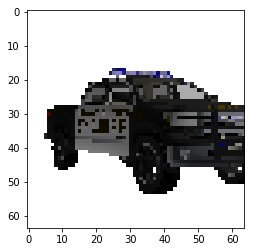

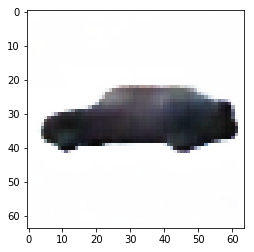

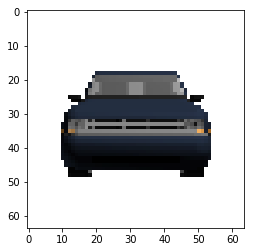

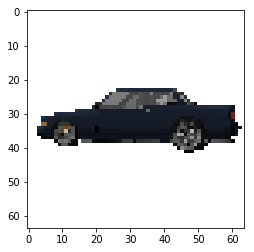

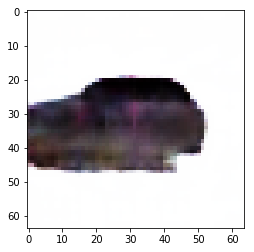

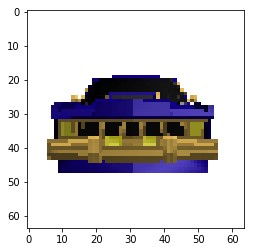

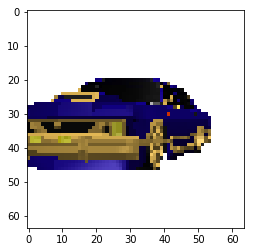

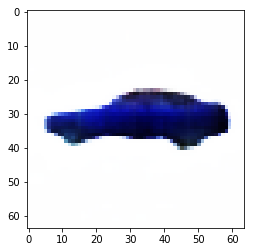

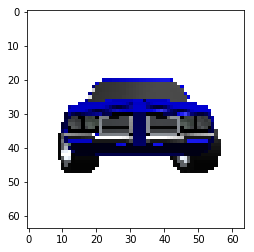

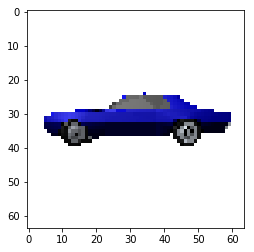

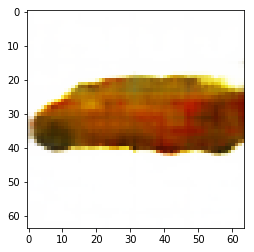

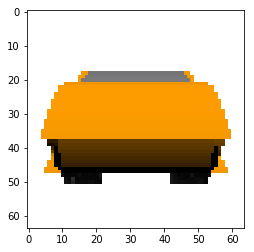

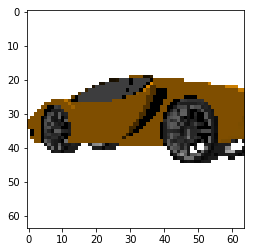

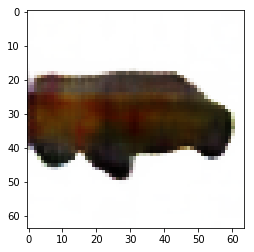

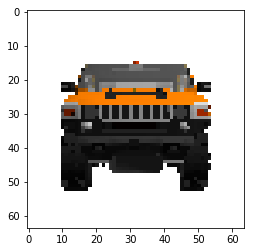

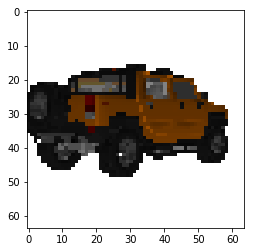

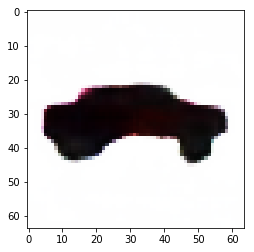

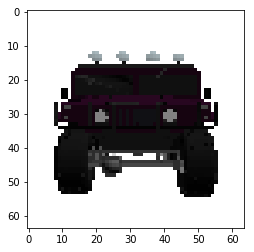

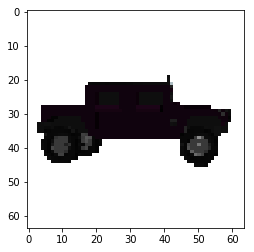

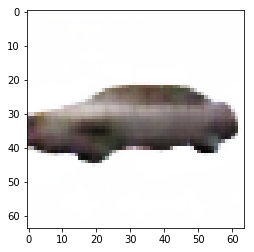

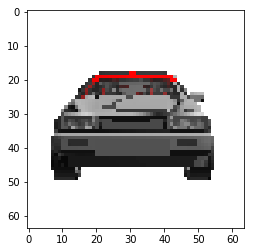

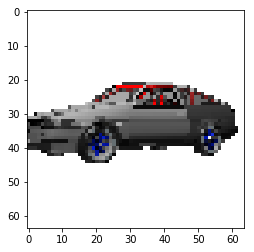

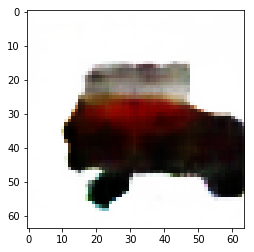

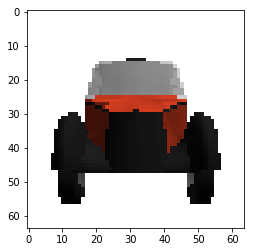

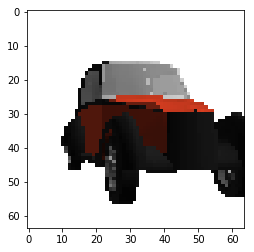

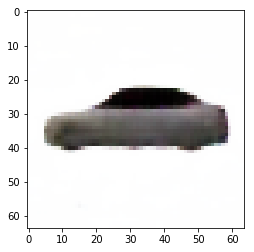

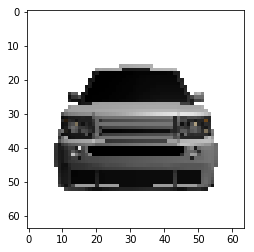

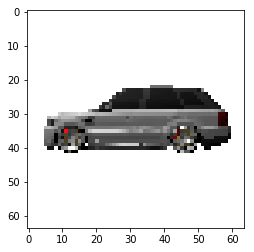

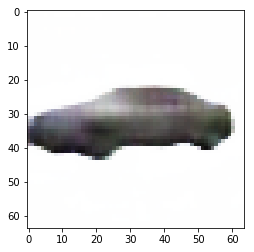

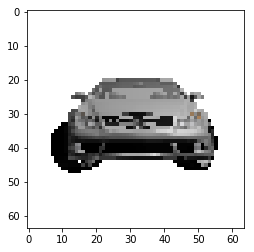

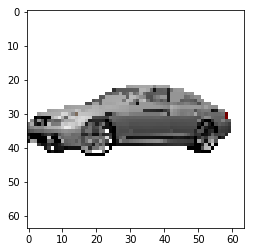

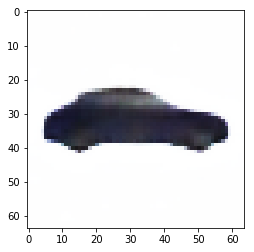

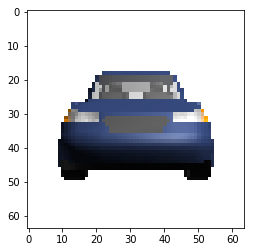

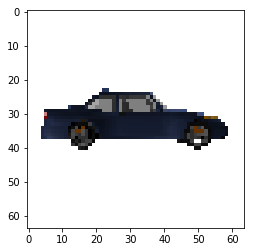

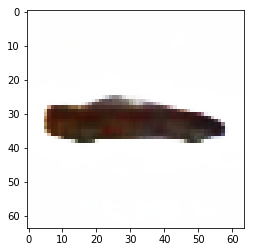

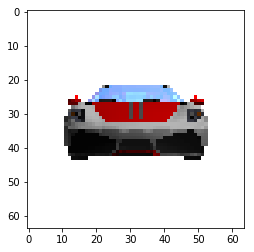

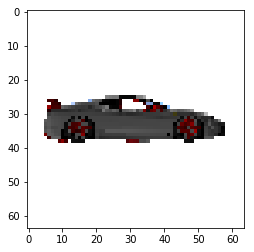

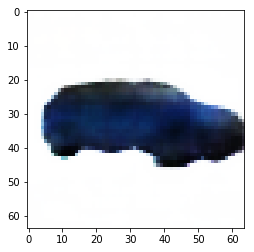

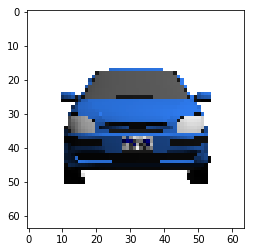

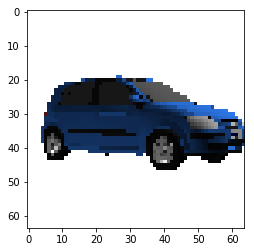

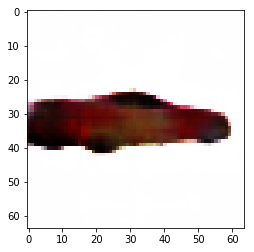

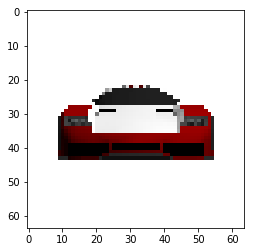

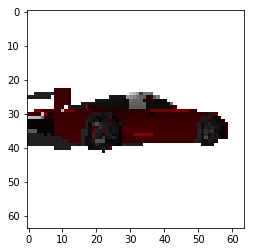

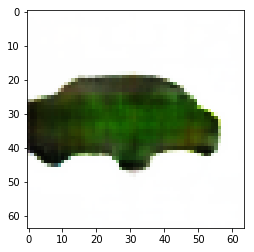

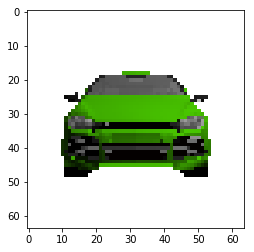

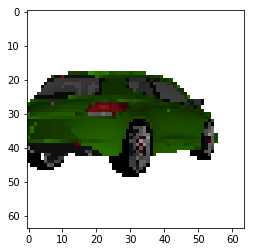

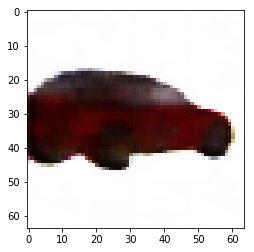

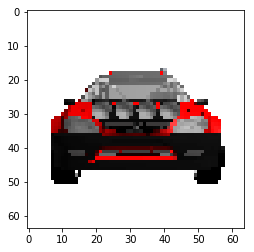

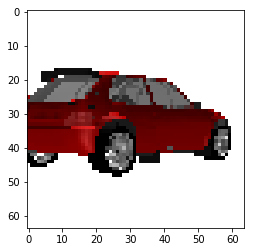

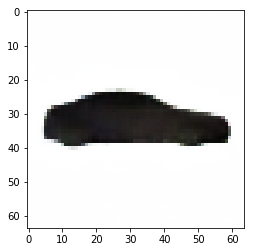

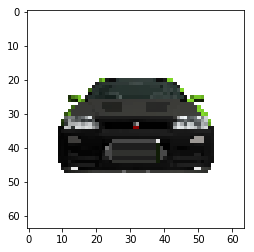

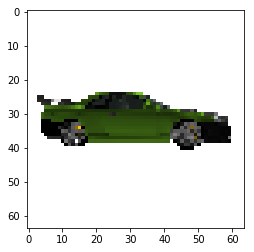

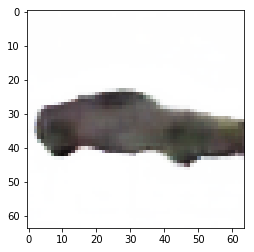

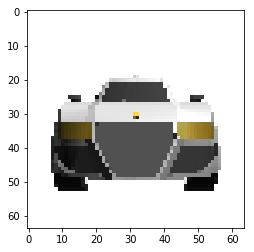

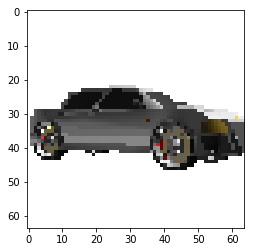

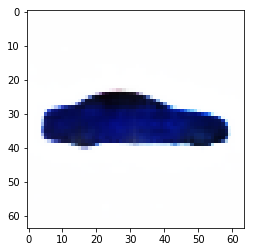

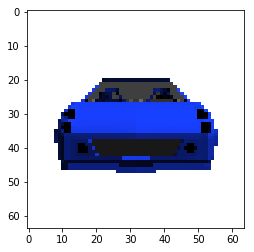

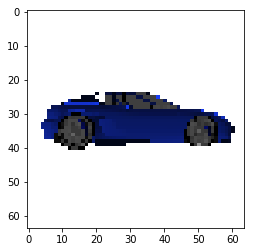

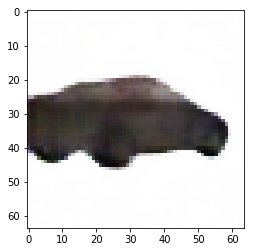

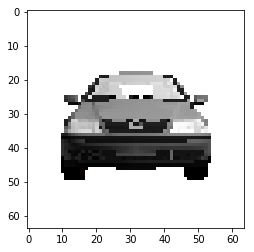

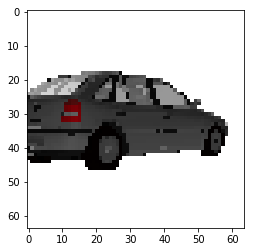

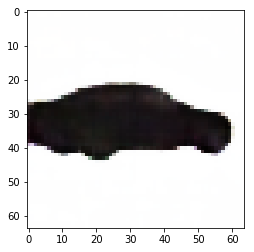

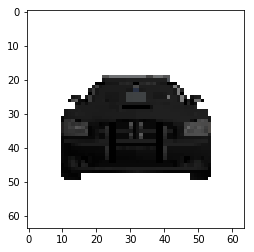

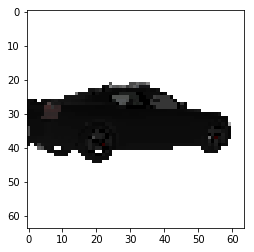

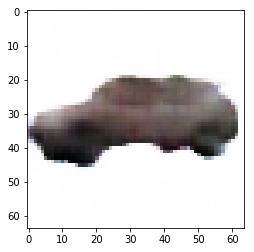

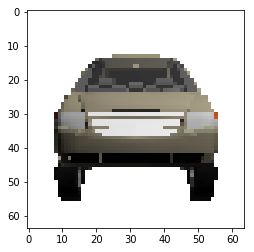

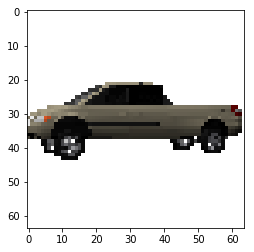

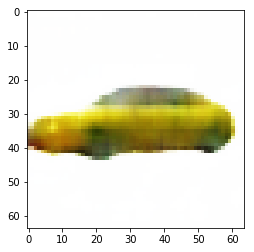

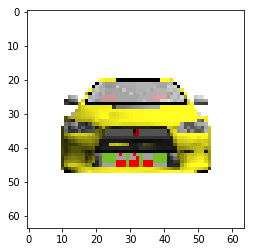

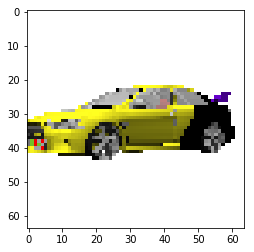

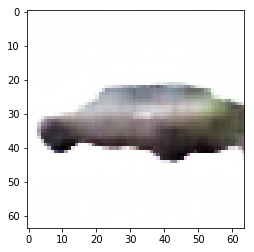

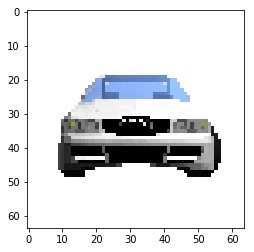

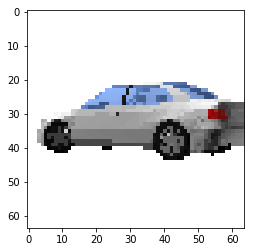

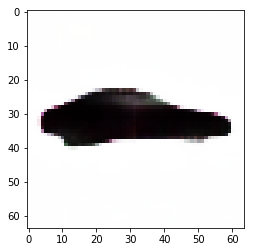

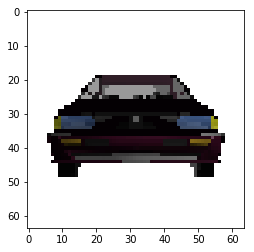

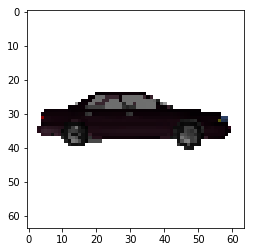

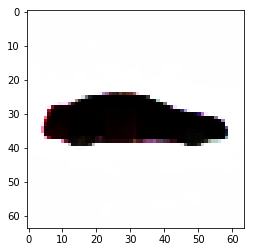

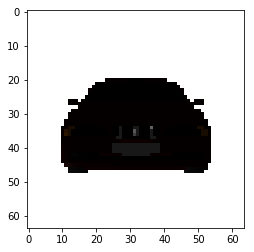

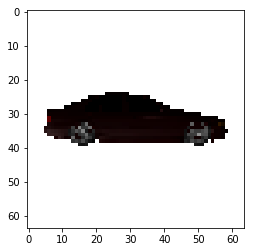

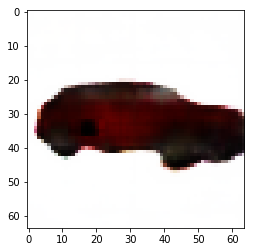

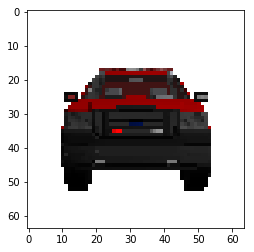

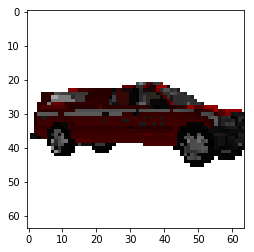

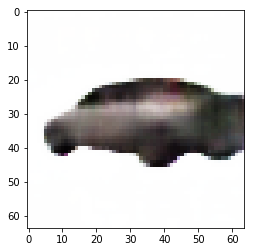

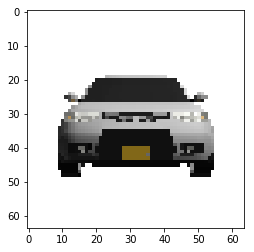

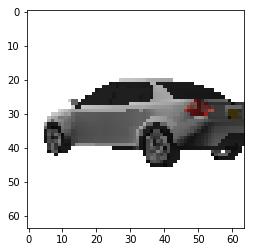

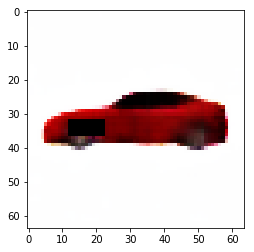

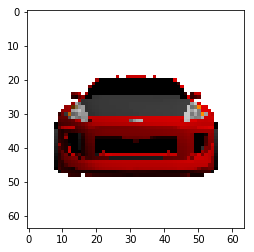

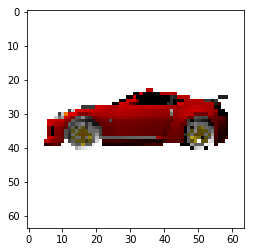

In [31]:
for j in range(batch_size):
    tmp = op[j]
    plt.imshow(tmp / 255)
    plt.show()

    plt.imshow(denormalize(test_batch[j])/255)
    plt.show()

    plt.imshow(denormalize(test_labels[j])/255)
    plt.show()